##  Libraries

In [1]:
# Load PyTorch and Essential Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import sys

# Data augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
import pathlib
from tqdm import tqdm

# Geospatial data
import rioxarray as rxr
import rasterio

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score

# File operations
import requests
import pyunpack
from rarfile import RarFile

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda
GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Memory: 8.00 GB


## Old Trainning Loop

In [3]:
# Training Functions

def compute_metrics(pred, target):
    """
    Compute accuracy and MSE metrics.
    Matches TensorFlow metrics=['accuracy', 'mse'].
    
    Args:
        pred: predicted masks (B, 1, H, W)
        target: ground truth masks (B, 1, H, W)
    
    Returns:
        accuracy, mse
    """

    # 1. Convert Logits to Probabilities for Metrics
    probs = torch.sigmoid(pred)

    pred_binary = (probs > 0.5).float()
    
    # Accuracy: percentage of correct pixels
    accuracy = (pred_binary == target).float().mean().item()
    
    # MSE: mean squared error
    mse = F.mse_loss(probs, target).item()
    
    return accuracy, mse

def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs=30, steps_per_epoch=100, device='cuda',
                save_path='model.pth', verbose=1):
    """
    Training loop matching TensorFlow model.fit().
    
    Args:
        model: PyTorch model
        train_loader: training DataLoader
        val_loader: validation DataLoader
        criterion: loss function
        optimizer: optimizer
        num_epochs: number of epochs
        steps_per_epoch: iterations per epoch (matches TF)
        device: 'cuda' or 'cpu'
        save_path: path to save best model
        verbose: print frequency (0=silent, 1=progress bar, 2=one line per epoch)
    
    Returns:
        history: dict with training metrics
    """
    model.to(device)
    best_val_acc = 0.0
    
    history = {
        'loss': [],
        'accuracy': [],
        'mse': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_mse': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        train_mse = 0.0
        
        # Create iterator and control steps per epoch
        train_iter = iter(train_loader)
        
        # Progress bar for training
        if verbose == 1:
            pbar = tqdm(range(steps_per_epoch), desc=f'Epoch {epoch+1}/{num_epochs}')
        else:
            pbar = range(steps_per_epoch)
        
        for step in pbar:
            try:
                images, masks = next(train_iter)
            except StopIteration:
                # Reset iterator when exhausted
                train_iter = iter(train_loader)
                images, masks = next(train_iter)
            
            images = images.to(device)
            #masks = masks.to(device)
            masks = masks.to(device).float()

            if len(masks.shape) == 3:#
                masks = masks.unsqueeze(1)#
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Compute metrics
            acc, mse = compute_metrics(outputs, masks)
            
            train_loss += loss.item()
            train_acc += acc
            train_mse += mse
            
            # Update progress bar
            if verbose == 1:
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{acc:.4f}'
                })
        
        # Average training metrics
        train_loss /= steps_per_epoch
        train_acc /= steps_per_epoch
        train_mse /= steps_per_epoch
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        val_mse = 0.0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device).float()

                if len(masks.shape) == 3:#
                    masks = masks.unsqueeze(1)#
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                acc, mse = compute_metrics(outputs, masks)
                
                val_loss += loss.item()
                val_acc += acc
                val_mse += mse
        
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        val_mse /= len(val_loader)
        
        # Save best model (matching ModelCheckpoint behavior)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss
            }, save_path)
            if verbose >= 1:
                print(f"\nEpoch {epoch+1}: val_accuracy improved to {val_acc:.4f}, saving model to {save_path}")
        
        # Store history
        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)
        history['mse'].append(train_mse)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)
        history['val_mse'].append(val_mse)
        
        # Print epoch summary
        if verbose == 2 or (verbose == 1 and epoch % 5 == 0):
            print(f"Epoch {epoch+1}/{num_epochs} - "
                  f"loss: {train_loss:.4f} - acc: {train_acc:.4f} - mse: {train_mse:.4f} - "
                  f"val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f} - val_mse: {val_mse:.4f}")
    
    return history

def plot_training_history(history, save_path=None):
    """
    Plot training history matching TensorFlow style.
    
    Args:
        history: dict with keys ['loss', 'accuracy', 'val_loss', 'val_accuracy']
        save_path: optional path to save figure
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Accuracy plot
    axes[0].plot(history['accuracy'], label='Training')
    axes[0].plot(history['val_accuracy'], label='Validation')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].legend(loc='upper left')
    axes[0].grid(True)
    
    # Loss plot
    axes[1].plot(history['loss'], label='Training')
    axes[1].plot(history['val_loss'], label='Validation')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Model Loss')
    axes[1].legend(loc='upper left')
    axes[1].grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()

## Old Model arquitecture 

In [24]:
# Model 2: Attention U-Net (PRIMARY MODEL)

class AttentionBlock(nn.Module):
    """
    Attention Gate for Attention U-Net.
    
    Implements the attention mechanism from:
    "Attention U-Net: Learning Where to Look for the Pancreas"
    
    TensorFlow operations converted:
    - K.int_shape() → tensor.shape
    - tf.broadcast_to() → tensor.expand_as()
    - multiply() → *
    """
    def __init__(self, F_g, F_l, F_int):
        """
        Args:
            F_g: number of filters in gating signal
            F_l: number of filters in skip connection
            F_int: number of intermediate filters
        """
        super(AttentionBlock, self).__init__()
        
        # Gating signal pathway
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            #nn.BatchNorm2d(F_int)
        )
        
        # Skip connection pathway
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            #nn.BatchNorm2d(F_int)
        )
        
        # Attention coefficient
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            #nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        """
        Args:
            g: gating signal from decoder (coarser scale)
            x: skip connection from encoder (finer scale)
        
        Returns:
            attention-weighted skip connection
        """
        # Process gating signal
        g1 = self.W_g(g)
        
        # Process skip connection with max pooling to match gating size
        # TF: MaxPooling2D((2,2))(theta_x)

        x1 = self.W_x(x)
        x1 = F.max_pool2d(x1, kernel_size=2, stride=2)

        # Combine and apply attention
        # TF: add([phi_g, theta_x])
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        
        # Upsample attention map to match skip connection size
        # TF: UpSampling2D(...) then tf.broadcast_to()
        psi = F.interpolate(psi, size=x.shape[2:], mode='bilinear', align_corners=True)
        
        # Apply attention: multiply with skip connection
        # TF: multiply([upsample_psi, x])
        out = x * psi
        
        return out

class AttentionUNet(nn.Module):
    """
    Attention U-Net architecture.
    Matches TensorFlow UNetAM implementation.
    
    Architecture:
    - Encoder: 4 blocks with progressive filters
    - Bottleneck: Highest filter count
    - Decoder: 4 blocks with attention gates
    - Attention gates applied at each decoder level
    """
    def __init__(self, in_channels=3, out_channels=1, filter_base=16):
        """
        Args:
            in_channels: input channels (3 for RGB, 4 for 4-band)
            out_channels: output channels (1 for binary)
            filter_base: base number of filters (16 in original)
        """
        super(AttentionUNet, self).__init__()
        
        # Calculate filter sizes matching TensorFlow
        # filters = [16, 32, 64, 128, 256]
        filters = [filter_base * (2**i) for i in range(5)]
        
        # Encoder
        self.encoder1 = self._conv_block(in_channels, filters[0])
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.encoder2 = self._conv_block(filters[0], filters[1])
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.encoder3 = self._conv_block(filters[1], filters[2])
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.encoder4 = self._conv_block(filters[2], filters[3])
        self.pool4 = nn.MaxPool2d(2, 2)
        
        # Bottleneck
        self.bottleneck = self._conv_block(filters[3], filters[4])
        
        # Attention gates
        self.att4 = AttentionBlock(F_g=filters[4], F_l=filters[3], F_int=filters[3])
        self.att3 = AttentionBlock(F_g=filters[3], F_l=filters[2], F_int=filters[2])
        self.att2 = AttentionBlock(F_g=filters[2], F_l=filters[1], F_int=filters[1])
        self.att1 = AttentionBlock(F_g=filters[1], F_l=filters[0], F_int=filters[0])
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(filters[4], filters[3], kernel_size=2, stride=2)
        self.decoder4 = self._conv_block(filters[4], filters[3])
        
        self.upconv3 = nn.ConvTranspose2d(filters[3], filters[2], kernel_size=2, stride=2)
        self.decoder3 = self._conv_block(filters[3], filters[2])
        
        self.upconv2 = nn.ConvTranspose2d(filters[2], filters[1], kernel_size=2, stride=2)
        self.decoder2 = self._conv_block(filters[2], filters[1])
        
        self.upconv1 = nn.ConvTranspose2d(filters[1], filters[0], kernel_size=2, stride=2)
        self.decoder1 = self._conv_block(filters[1], filters[0])
        
        # Output
        self.conv_out = nn.Conv2d(filters[0], out_channels, kernel_size=1)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
    def _conv_block(self, in_channels, out_channels):
        """
        Matches convBlock2 from TensorFlow.
        Two convolutions with ReLU activations.
        """
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(enc4))
        
        # Decoder with attention gates
        # Level 4
        d4 = self.upconv4(bottleneck)
        enc4_att = self.att4(g=bottleneck, x=enc4)
        d4 = torch.cat([d4, enc4_att], dim=1)
        d4 = self.decoder4(d4)
        
        # Level 3
        d3 = self.upconv3(d4)
        enc3_att = self.att3(g=d4, x=enc3)
        d3 = torch.cat([d3, enc3_att], dim=1)
        d3 = self.decoder3(d3)
        
        # Level 2
        d2 = self.upconv2(d3)
        enc2_att = self.att2(g=d3, x=enc2)
        d2 = torch.cat([d2, enc2_att], dim=1)
        d2 = self.decoder2(d2)
        
        # Level 1
        d1 = self.upconv1(d2)
        enc1_att = self.att1(g=d2, x=enc1)
        d1 = torch.cat([d1, enc1], dim=1)#torch.cat([d1, enc1_att], dim=1)#torch.cat([d1, enc1], dim=1)#torch.cat([d1, enc1_att], dim=1)
        d1 = self.decoder1(d1)
        
        # Output
        out = self.conv_out(d1)#torch.sigmoid(self.conv_out(d1))
        
        return out

## Loading Data

In [2]:
import os
import glob
import numpy as np
import torch
import rasterio
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2

# --- CONFIGURATION ---
# Point this to your main folder containing 'images' and 'masks'
base_dir = "/home/dhuencho/dev_py/0001_start_pytorch/src/UCL_AI4SD/CW2/attention-mechanism-unet/chile/Validation" 
BATCH_SIZE = 2

def get_4band_transforms(split="train", img_size=512):
    transforms_list = [
        A.Resize(height=img_size, width=img_size, interpolation=cv2.INTER_LINEAR),
    ]
    
    if split == "train":
        transforms_list.extend([
            # Geometric Augmentations (Safe for 4-Band)
            A.Rotate(limit=180, border_mode=cv2.BORDER_REFLECT_101, p=0.7),
            A.ShiftScaleRotate(
                shift_limit=0.25, 
                scale_limit=0.25, 
                rotate_limit=0, 
                border_mode=cv2.BORDER_REFLECT_101, 
                p=0.7
            ),
            A.Affine(shear=(-14, 14), border_mode=cv2.BORDER_REFLECT_101, p=0.5),
            A.HorizontalFlip(p=0.7),
            A.VerticalFlip(p=0.7),
        ])
    
    transforms_list.append(ToTensorV2())
    return A.Compose(transforms_list)

class FourBandAmazonDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # A. Load 4-Band Image
        with rasterio.open(self.image_paths[idx]) as src:
            # Transpose (C, H, W) -> (H, W, C) for Albumentations
            image = src.read().transpose(1, 2, 0).astype(np.float32)

            # Normalization
            img_min = image.min()
            img_max = image.max()
            image = (image - img_min) / (img_max - img_min + 1e-8)

        # B. Load Mask
        with rasterio.open(self.mask_paths[idx]) as src:
            mask = src.read(1).astype(np.float32)

        # Match Dimensions (Crop if needed)
        h, w = image.shape[:2]
        mh, mw = mask.shape[:2]
        
        if mh != h or mw != w:
            mask = mask[:h, :w]

        # C. Apply Transforms
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        # D. Final Formatting
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask)
        
        mask = mask.long() # Shape (H, W) for CrossEntropy

        return image, mask

def get_all_filepaths(root_dir):
    """
    Reads all files from root_dir/images and matches them with root_dir/masks
    """
    img_dir = os.path.join(root_dir, "images")
    mask_dir = os.path.join(root_dir, "masks")
    
    # Sort to ensure alignment
    image_files = sorted(glob.glob(os.path.join(img_dir, "*")))
    
    mask_files = []
    valid_imgs = []
    
    for img_path in image_files:
        filename = os.path.basename(img_path)
        mask_path = os.path.join(mask_dir, filename)
        
        # Check if corresponding mask exists
        if os.path.exists(mask_path):
            valid_imgs.append(img_path)
            mask_files.append(mask_path)
        else:
            print(f"⚠️ Warning: Mask not found for {filename}, skipping.")
            
    return valid_imgs, mask_files

# --- MAIN EXECUTION ---

# 1. Get ALL Data
print("Scanning files...")
all_imgs, all_masks = get_all_filepaths(base_dir)
print(f"Found {len(all_imgs)} valid image/mask pairs.")

# 2. Perform Split (80% Train, 10% Val, 10% Test)
# First split: 80% Train, 20% Temp
train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(
    all_imgs, all_masks, test_size=0.20, random_state=42, shuffle=True
)

# Second split: Split the 20% Temp into 10% Val and 10% Test
val_imgs, test_imgs, val_masks, test_masks = train_test_split(
    temp_imgs, temp_masks, test_size=0.50, random_state=42, shuffle=True
)

print(f"Split breakdown: Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")

# 3. Create Datasets
train_ds = FourBandAmazonDataset(train_imgs, train_masks, transform=get_4band_transforms("train"))
val_ds = FourBandAmazonDataset(val_imgs, val_masks, transform=get_4band_transforms("val")) # No geometric aug
test_ds = FourBandAmazonDataset(test_imgs, test_masks, transform=get_4band_transforms("val"))  # No geometric aug

# 4. Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("✅ 4-Band Pipeline Ready with Auto-Split")

Scanning files...
Found 40 valid image/mask pairs.
Split breakdown: Train: 32, Val: 4, Test: 4
✅ 4-Band Pipeline Ready with Auto-Split


/home/dhuencho/dev_py/0001_start_pytorch/.venv/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [3]:
images, masks = next(iter(train_loader))
print(f"Image shape: {images.shape}")

Image shape: torch.Size([2, 4, 512, 512])


VISUALIZING TRAINING DATA (Should show rotation/flips/reflection):
--- Visualizing 3 Samples from 4-Band Dataset ---


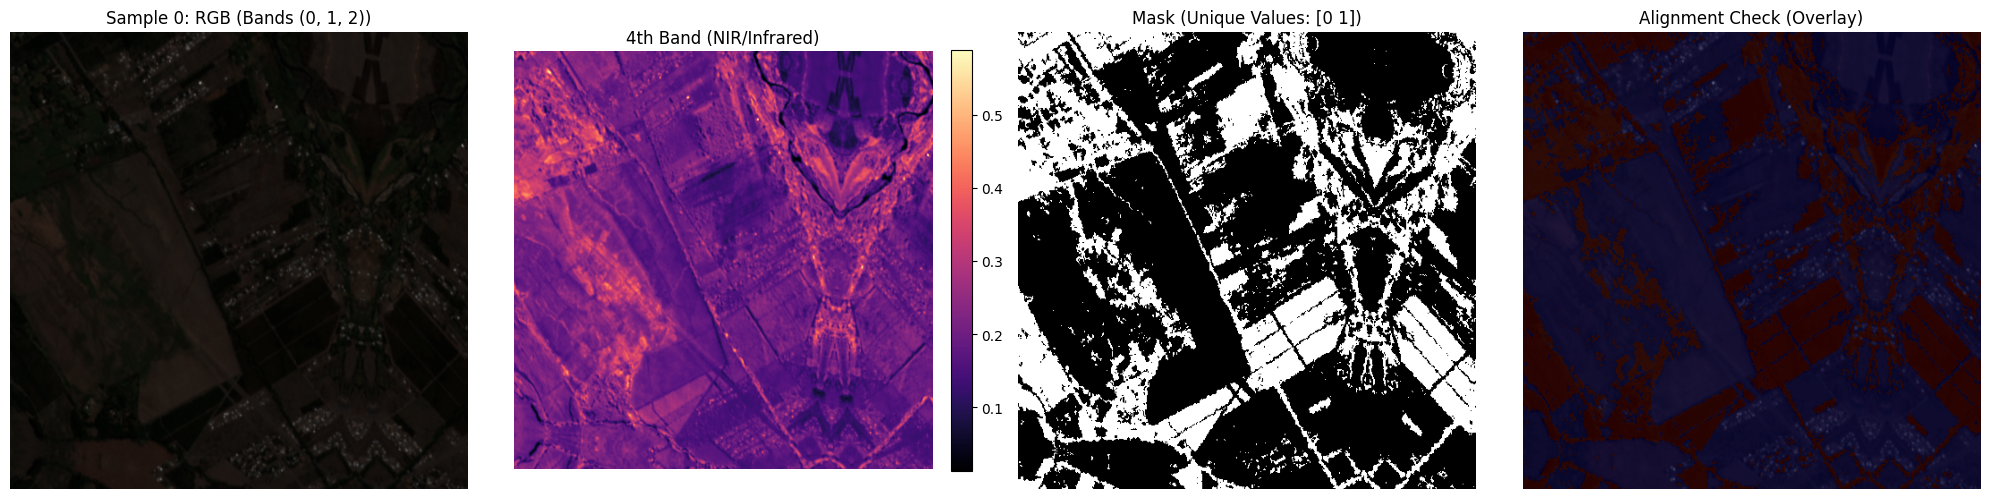

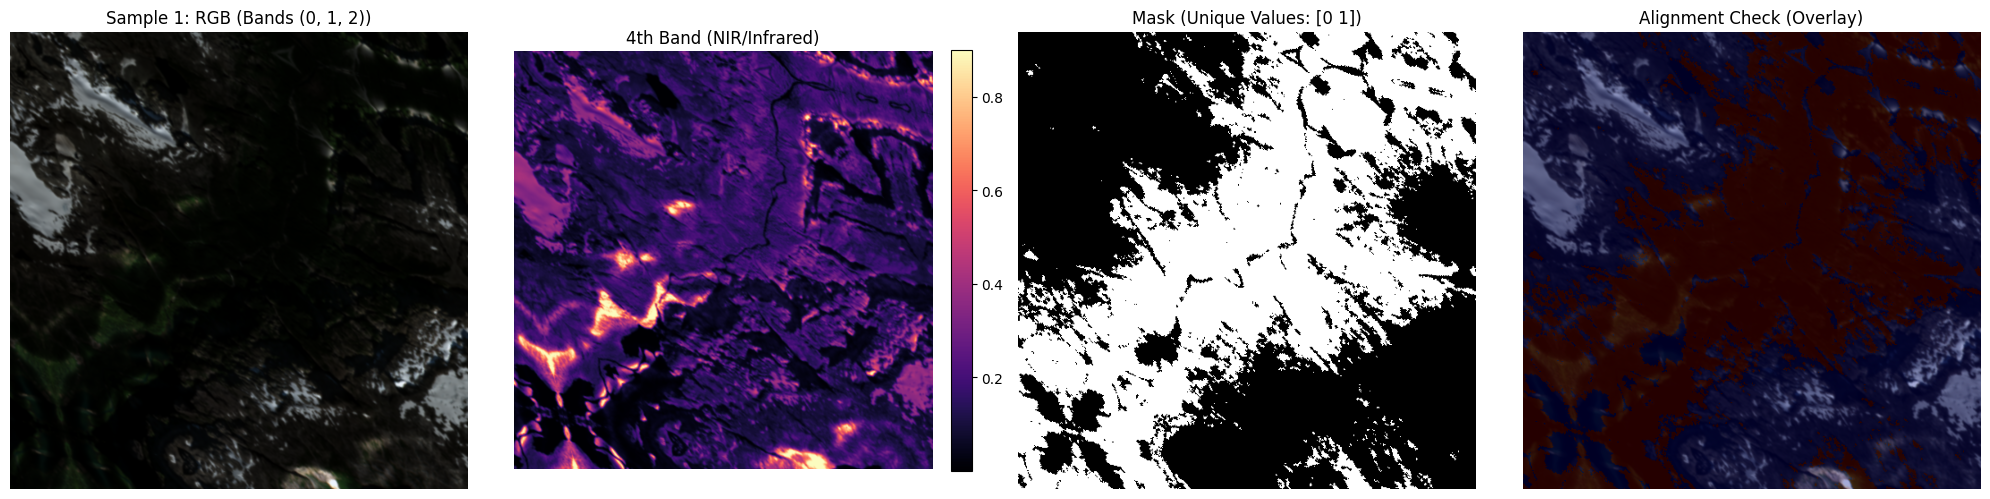

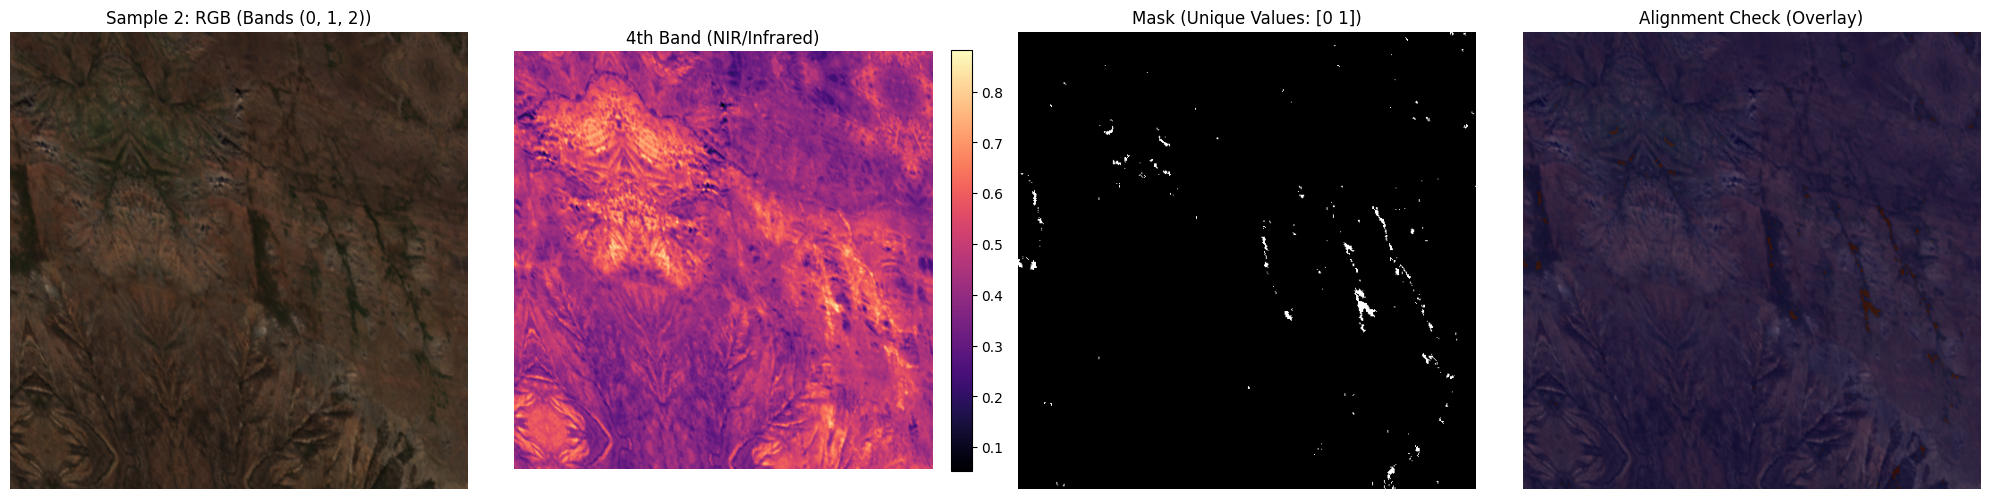


VISUALIZING VALIDATION DATA (Should be standard):
--- Visualizing 2 Samples from 4-Band Dataset ---


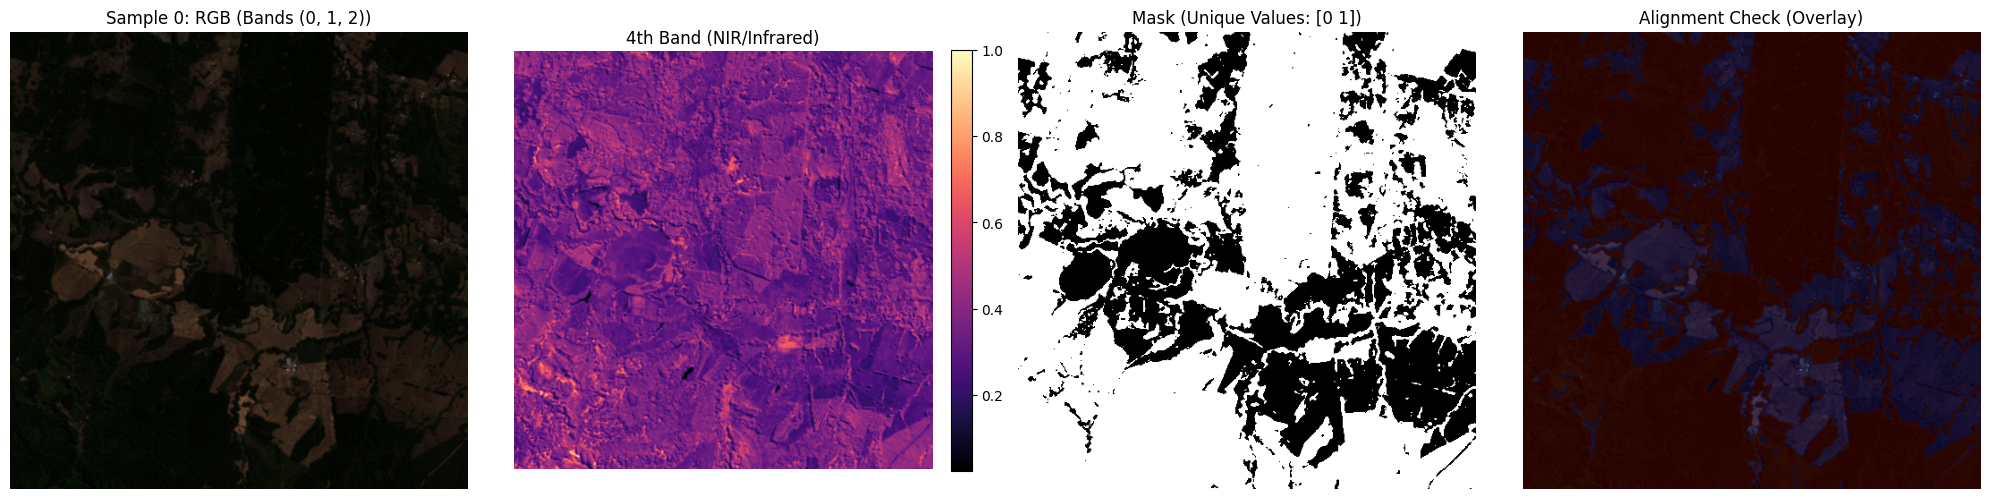

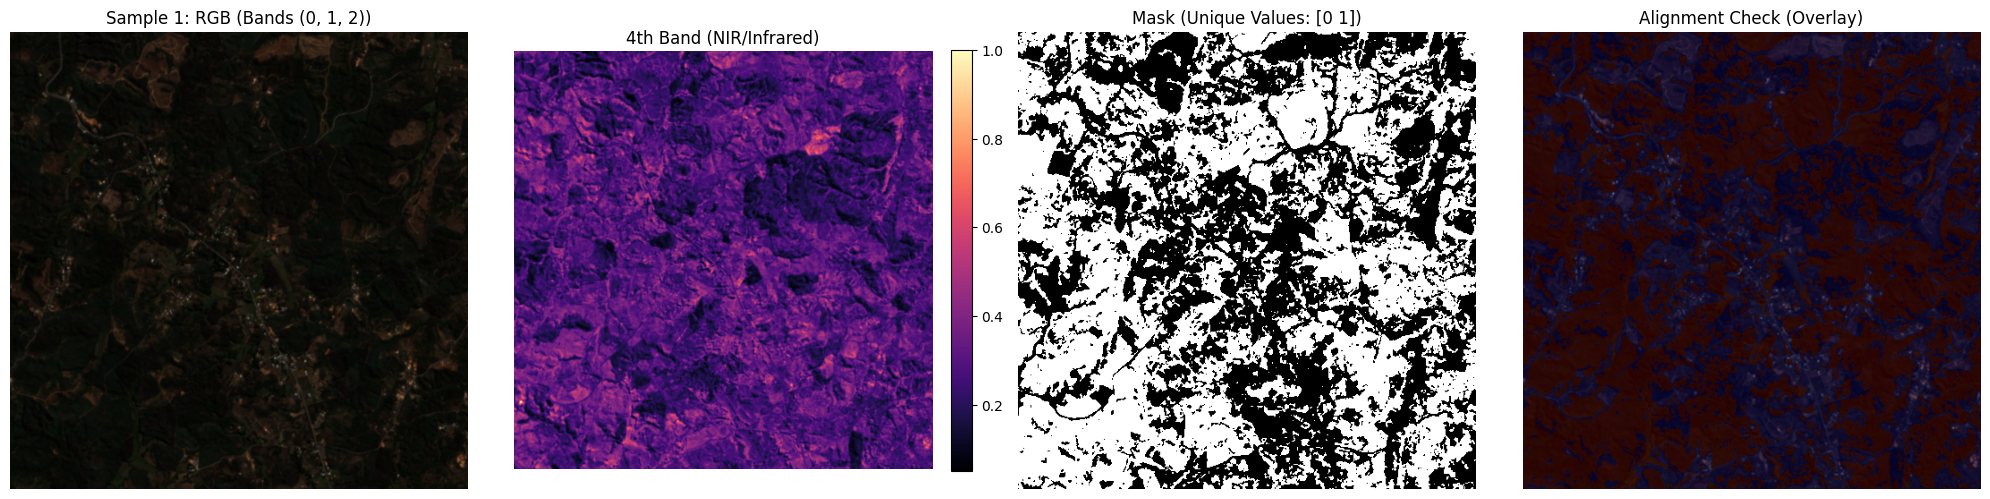

In [4]:

def visualize_4band_dataset(dataset, num_samples=3, band_order=(0, 1, 2)):
    """
    Visualizes 4-band imagery by splitting it into RGB and the 4th Band (NIR).
    
    Args:
        dataset: Your PyTorch dataset (FourBandAmazonDataset)
        num_samples: How many images to show
        band_order: Indices of (Red, Green, Blue) bands. 
                    Default (0,1,2) assumes the Tiff is saved as R-G-B-NIR.
    """
    
    # Create a small loader to get a batch
    # We use batch_size=1 just to grab samples easily
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
    
    print(f"--- Visualizing {num_samples} Samples from 4-Band Dataset ---")
    
    for i, (image, mask) in enumerate(loader):
        if i >= num_samples:
            break
            
        # 1. Unpack Tensor: (1, 4, H, W) -> (4, H, W)
        img_tensor = image.squeeze(0)
        mask_tensor = mask.squeeze(0)
        
        # 2. Extract RGB Channels for display
        # We assume the image is already normalized 0-1 by your Dataset class
        r_band = img_tensor[band_order[0], :, :].numpy()
        g_band = img_tensor[band_order[1], :, :].numpy()
        b_band = img_tensor[band_order[2], :, :].numpy()
        
        # Stack them to create a standard RGB image for Matplotlib
        rgb_img = np.stack([r_band, g_band, b_band], axis=-1)
        
        # 3. Extract the 4th Band (Usually NIR - Near Infrared)
        # We assume it is at index 3 (the last one)
        nir_band = img_tensor[3, :, :].numpy()
        
        # 4. Process Mask (Remove extra dims)
        mask_img = mask_tensor.squeeze().numpy()

        # --- PLOTTING ---
        fig, ax = plt.subplots(1, 4, figsize=(20, 5))
        
        # A. RGB Composition
        ax[0].imshow(rgb_img)
        ax[0].set_title(f"Sample {i}: RGB (Bands {band_order})")
        ax[0].axis('off')
        
        # B. 4th Band (Heatmap style)
        # We use a colormap to see the signal intensity clearly
        im_nir = ax[1].imshow(nir_band, cmap='magma')
        ax[1].set_title("4th Band (NIR/Infrared)")
        ax[1].axis('off')
        plt.colorbar(im_nir, ax=ax[1], fraction=0.046, pad=0.04)
        
        # C. Ground Truth Mask
        ax[2].imshow(mask_img, cmap='gray')
        ax[2].set_title(f"Mask (Unique Values: {np.unique(mask_img)})")
        ax[2].axis('off')
        
        # D. Overlay (Check Alignment)
        # We plot the mask ON TOP of the RGB image with transparency (alpha)
        ax[3].imshow(rgb_img)
        ax[3].imshow(mask_img, cmap='jet', alpha=0.3) # 30% transparent mask
        ax[3].set_title("Alignment Check (Overlay)")
        ax[3].axis('off')
        
        plt.tight_layout()
        plt.show()

# --- RUN IT ---
# Try checking both Training (Augmented) and Validation (Raw)
print("VISUALIZING TRAINING DATA (Should show rotation/flips/reflection):")
visualize_4band_dataset(train_ds, num_samples=3)

print("\nVISUALIZING VALIDATION DATA (Should be standard):")
visualize_4band_dataset(val_ds, num_samples=2)

## Training



In [5]:
# Training Configuration

# Create directories for saving models and figures
os.makedirs('models_pytorch', exist_ok=True)
os.makedirs('figures_pytorch', exist_ok=True)
os.makedirs('metrics_pytorch', exist_ok=True)

# Loss function
#criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()

print("Setup complete. Ready for training.")

Setup complete. Ready for training.


In [ ]:
# Attention U-Net on RGB (3-channel)

print("Training Attention U-Net on RGB data...\n")

model_attn_unet_4band = AttentionUNet(in_channels=4, out_channels=1, filter_base=16).to(device)
optimizer_attn_unet_4band = torch.optim.Adam(model_attn_unet_4band.parameters(), lr=0.0005,
                                           betas=(0.9, 0.999), eps=1e-7)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer_attn_unet_4band, mode='min', factor=0.1, patience=5, verbose=True
# )                                           

history_attn_unet_4band = train_model(
    model_attn_unet_4band,
    train_loader_4band,
    val_loader_4band,
    criterion,
    optimizer_attn_unet_4band,
    num_epochs=60,
    steps_per_epoch=100,
    device=device,
    save_path='models_pytorch/attention-unet-4d.pth',
    verbose=1
)

# Save history
np.save('models_pytorch/attention-unet-4d-history.npy', history_attn_unet_4band)

# Plot training curves
plot_training_history(history_attn_unet_4band,
                     save_path='figures_pytorch/attention-unet-4d-history.png')

## New pipeline

In [6]:
# --- 1. Global Setup (Run ONCE to save time) ---
# Define your base directory
base_dir = "/home/dhuencho/dev_py/0001_start_pytorch/src/UCL_AI4SD/CW2/attention-mechanism-unet/chile/Validation"

# Helper function to get filepaths (from your code)
def get_all_filepaths(root_dir):
    img_dir = os.path.join(root_dir, "images")
    mask_dir = os.path.join(root_dir, "masks")
    image_files = sorted(glob.glob(os.path.join(img_dir, "*")))
    mask_files = []
    valid_imgs = []
    for img_path in image_files:
        filename = os.path.basename(img_path)
        mask_path = os.path.join(mask_dir, filename)
        if os.path.exists(mask_path):
            valid_imgs.append(img_path)
            mask_files.append(mask_path)
    return valid_imgs, mask_files

# Scan files once
print("Scanning files...")
all_imgs, all_masks = get_all_filepaths(base_dir)

# Perform Split (80% Train, 10% Val, 10% Test)
# We make these variables GLOBAL so the objective function can access them instantly
TRAIN_IMG, VAL_IMG, TRAIN_MASK, VAL_MASK = train_test_split(
    all_imgs, all_masks, test_size=0.40, random_state=42, shuffle=True
)
# VAL_IMG, TEST_IMG, VAL_MASK, TEST_MASK = train_test_split(
#     temp_imgs, temp_masks, test_size=0.0, random_state=42, shuffle=True
# )

print(f"Ready for Optuna: Train: {len(TRAIN_IMG)}, Val: {len(VAL_IMG)}")

Scanning files...
Ready for Optuna: Train: 24, Val: 16


In [7]:
def get_dataloaders(batch_size, num_workers=2):
    """
    Creates DataLoaders using the pre-loaded global file lists.
    Args:
        batch_size: Int, defined by Optuna or fixed config.
    """
    # 1. Create Datasets (Re-instantiated per trial to ensure clean state)
    train_ds = FourBandAmazonDataset(
        TRAIN_IMG, 
        TRAIN_MASK, 
        transform=get_4band_transforms("train")
    )
    
    val_ds = FourBandAmazonDataset(
        VAL_IMG, 
        VAL_MASK, 
        transform=get_4band_transforms("val") # No geometric aug for validation
    )

    # 2. Create Loaders
    # Pin_memory=True speeds up transfer to CUDA
    train_loader = DataLoader(
        train_ds, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True # Prevents error on last incomplete batch if using BatchNorm
    )
    
    val_loader = DataLoader(
        val_ds, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False
    )
    
    return train_loader, val_loader

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import optuna

# --- AttentionBlock remains unchanged from previous step ---
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        x1 = F.max_pool2d(x1, kernel_size=2, stride=2)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        psi = F.interpolate(psi, size=x.shape[2:], mode='bilinear', align_corners=True)
        return x * psi

class FlexibleAttentionUNet(nn.Module):
    """
    Flexible Attention U-Net with Dynamic Depth and Dropout.
    """
    def __init__(self, in_channels=3, out_channels=1, depth=4, filter_base=16, 
                 use_batchnorm=False, dropout_rate=0.0):
        super(FlexibleAttentionUNet, self).__init__()
        self.depth = depth
        self.dropout_rate = dropout_rate
        
        # Dynamic filter calculation
        self.filters = [filter_base * (2**i) for i in range(depth + 1)]
        
        self.encoders = nn.ModuleList()
        self.pools = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.upconvs = nn.ModuleList()
        self.attentions = nn.ModuleList()
        
        # --- Encoder ---
        current_in = in_channels
        for i in range(depth):
            self.encoders.append(self._conv_block(current_in, self.filters[i], use_batchnorm))
            self.pools.append(nn.MaxPool2d(2, 2))
            current_in = self.filters[i]
            
        # --- Bottleneck ---
        self.bottleneck = self._conv_block(self.filters[depth-1], self.filters[depth], use_batchnorm)
        
        # --- Decoder ---
        for i in range(depth - 1, -1, -1):
            self.upconvs.append(nn.ConvTranspose2d(self.filters[i+1], self.filters[i], kernel_size=2, stride=2))
            self.attentions.append(AttentionBlock(F_g=self.filters[i+1], F_l=self.filters[i], F_int=self.filters[i]))
            # Note: Decoder input filters are doubled due to concatenation
            self.decoders.append(self._conv_block(self.filters[i] * 2, self.filters[i], use_batchnorm))
            
        self.conv_out = nn.Conv2d(self.filters[0], out_channels, kernel_size=1)
        self._init_weights()

    def _conv_block(self, in_c, out_c, batchnorm):
        """
        Constructs a block: Conv -> BN (opt) -> ReLU -> Dropout (opt) -> Conv -> ...
        """
        layers = []
        
        # 1st Conv
        layers.append(nn.Conv2d(in_c, out_c, 3, padding=1))
        if batchnorm: layers.append(nn.BatchNorm2d(out_c))
        layers.append(nn.ReLU(inplace=True))
        
        # Expert Practice: Apply dropout between convolutions to regularize features
        if self.dropout_rate > 0:
            layers.append(nn.Dropout2d(p=self.dropout_rate))
            
        # 2nd Conv
        layers.append(nn.Conv2d(out_c, out_c, 3, padding=1))
        if batchnorm: layers.append(nn.BatchNorm2d(out_c))
        layers.append(nn.ReLU(inplace=True))
        
        # Optional: Additional dropout at the end of the block
        if self.dropout_rate > 0:
            layers.append(nn.Dropout2d(p=self.dropout_rate))
            
        return nn.Sequential(*layers)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        skips = []
        
        # Encoder
        for i in range(self.depth):
            x = self.encoders[i](x)
            skips.append(x)
            x = self.pools[i](x)
            
        x = self.bottleneck(x)
        
        # Decoder
        for i in range(self.depth):
            skip = skips[-(i+1)]
            g = x
            x = self.upconvs[i](x)
            attn = self.attentions[i](g=g, x=skip)
            x = torch.cat([x, attn], dim=1)
            x = self.decoders[i](x)
            
        return self.conv_out(x)

In [9]:
def test_flexible_architecture():
    # 1. Setup Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🔬 Running Robust Architecture Tests on: {device}\n")

    # 2. Define Test Cases
    # Format: (Test Name, Model Arguments, Input Channels, Image Size)
    test_cases = [
        (
            "Standard RGB U-Net (Depth 4)", 
            {'in_channels': 3, 'out_channels': 1, 'depth': 4, 'filter_base': 16, 'dropout_rate': 0.0},
            3, (512, 512)
        ),
        (
            "Sentinel 4-Band U-Net (Depth 4)", 
            {'in_channels': 4, 'out_channels': 1, 'depth': 4, 'filter_base': 16, 'dropout_rate': 0.1},
            4, (512, 512)
        ),
        (
            "Deep & Heavy (Depth 5, Filters 32)", 
            {'in_channels': 3, 'out_channels': 1, 'depth': 5, 'filter_base': 32, 'dropout_rate': 0.3},
            3, (256, 256) # Smaller size to fit in VRAM
        ),
        (
            "Shallow & Fast (Depth 2)", 
            {'in_channels': 4, 'out_channels': 1, 'depth': 2, 'filter_base': 16, 'use_batchnorm': True},
            4, (512, 512)
        ),
        (
            "Binary Output (Logits check)", 
            {'in_channels': 3, 'out_channels': 1, 'depth': 3, 'filter_base': 16},
            3, (128, 128)
        )
    ]

    # 3. Run Tests
    print(f"{'Test Case':<35} | {'Status':<8} | {'Shape':<20} | {'Params':<12} | {'NaN Check':<10}")
    print("-" * 105)

    for name, kwargs, in_ch, (h, w) in test_cases:
        # Create random input tensor
        batch_size = 1
        test_input = torch.randn(batch_size, in_ch, h, w).to(device)
        
        try:
            # Instantiate Model
            model = FlexibleAttentionUNet(**kwargs).to(device)
            model.eval()
            
            # Forward Pass
            with torch.no_grad():
                output = model(test_input)
            
            # Validation Checks
            expected_shape = (batch_size, kwargs['out_channels'], h, w)
            shape_ok = (output.shape == expected_shape)
            has_nan = torch.isnan(output).any().item()
            
            # Count Parameters
            num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            
            # Status Flags
            status = "PASS" if shape_ok and not has_nan else "FAIL"
            status_icon = "✓" if status == "PASS" else "✗"
            nan_status = "Clean" if not has_nan else "DETECTED!"
            
            # Print Result
            print(f"{status_icon} {name:<33} | {status:<8} | {str(tuple(output.shape)):<20} | {num_params:<12,} | {nan_status:<10}")
            
            # Detailed Error Reporting
            if not shape_ok:
                print(f"   >>> ERROR: Shape Mismatch! Expected {expected_shape}, got {output.shape}")
            if has_nan:
                print(f"   >>> ERROR: Numerical Instability! Output contains NaNs.")
                
        except Exception as e:
            # Catch crashes (e.g., OOM, channel mismatch)
            print(f"✗ {name:<33} | CRASHED  | {str(e)}")

    print("-" * 105)
    print("\n✅ All architecture tests completed.")

test_flexible_architecture()

🔬 Running Robust Architecture Tests on: cuda

Test Case                           | Status   | Shape                | Params       | NaN Check 
---------------------------------------------------------------------------------------------------------
✓ Standard RGB U-Net (Depth 4)      | PASS     | (1, 1, 512, 512)     | 2,007,109    | Clean     
✓ Sentinel 4-Band U-Net (Depth 4)   | PASS     | (1, 1, 512, 512)     | 2,007,253    | Clean     
✓ Deep & Heavy (Depth 5, Filters 32) | PASS     | (1, 1, 256, 256)     | 32,145,030   | Clean     
✓ Shallow & Fast (Depth 2)          | PASS     | (1, 1, 512, 512)     | 121,811      | Clean     
✓ Binary Output (Logits check)      | PASS     | (1, 1, 128, 128)     | 498,500      | Clean     
---------------------------------------------------------------------------------------------------------

✅ All architecture tests completed.


In [10]:
class EarlyStopping:
    """Expert Practice: Stop training if metric doesn't improve after 'patience' epochs"""
    def __init__(self, patience=5, min_delta=0.001, mode='max'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, current_score):
        if self.best_score is None:
            self.best_score = current_score
        
        # Check improvement based on mode (maximize or minimize)
        improved = False
        if self.mode == 'max':
            if current_score > self.best_score + self.min_delta:
                self.best_score = current_score
                improved = True
        elif self.mode == 'min':
            if current_score < self.best_score - self.min_delta:
                self.best_score = current_score
                improved = True
                
        if improved:
            self.counter = 0 # Reset if improved
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [11]:
def compute_metrics(pred, target):
    probs = torch.sigmoid(pred)
    pred_binary = (probs > 0.5).float()
    accuracy = (pred_binary == target).float().mean().item()
    return accuracy

def calculate_metrics(pred_logits, target_mask):
    """
    Computes Accuracy, MSE, and Dice Score.
    Args:
        pred_logits: (B, 1, H, W) float tensor
        target_mask: (B, H, W) or (B, 1, H, W) long/float tensor
    Returns:
        dict: {'acc': float, 'mse': float, 'dice': float}
    """
    # 1. Prepare predictions
    probs = torch.sigmoid(pred_logits)
    pred_binary = (probs > 0.5).float()
    
    # Ensure target shape matches predictions for element-wise ops
    if len(target_mask.shape) == 3:
        target_mask = target_mask.unsqueeze(1)
    target_float = target_mask.float()
    
    # 2. Accuracy
    correct = (pred_binary == target_float).sum()
    total = torch.numel(target_float)
    acc = (correct / total).item()
    
    # 3. Mean Squared Error
    # MSE between probabilities and binary target
    mse = F.mse_loss(probs, target_float).item()
    
    # 4. Dice Score
    # Dice = 2 * (pred & target) / (pred + target + epsilon)
    intersection = (pred_binary * target_float).sum()
    union = pred_binary.sum() + target_float.sum()
    dice = (2.0 * intersection / (union + 1e-8)).item()
    
    return {'acc': acc, 'mse': mse, 'dice': dice}

def train_model_optuna(trial, model, train_loader, val_loader, criterion, optimizer, 
                       num_epochs=10, device='cuda'):
    model.to(device)
    
    early_stopper = EarlyStopping(patience=6, mode='max')
    best_weighted_score = -float('inf')

    for epoch in range(num_epochs):
        model.train()
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device).float()
            if len(masks.shape) == 3: masks = masks.unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
        # Validation Phase
        model.eval()
        val_acc = 0.0
        val_metrics = {'acc': 0.0, 'mse': 0.0, 'dice': 0.0}
        steps = 0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device).float()
                if len(masks.shape) == 3: masks = masks.unsqueeze(1)
                outputs = model(images)
                val_acc += compute_metrics(outputs, masks)

                batch_metrics = calculate_metrics(outputs, masks)
                
                # Accumulate
                for k, v in batch_metrics.items():
                    val_metrics[k] += v
                steps += 1
        
        val_acc /= len(val_loader)

        for k in val_metrics:
            val_metrics[k] /= steps
        
        w_acc, w_dice, w_mse = 1.0, 1.5, 0.5
        weighted_score = (w_acc * val_metrics['acc']) + (w_dice * val_metrics['dice']) - (w_mse * val_metrics['mse'])
        # --- OPTUNA PRUNING ---
        # Report the current metric to Optuna

        # Track best score for this trial
        if weighted_score > best_weighted_score:
            best_weighted_score = weighted_score

        trial.report(weighted_score, epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        early_stopper(weighted_score)
        if early_stopper.early_stop:
            break
        
        trial.set_user_attr("epochs_run", epoch + 1)
            
    return val_metrics

In [30]:
def objective(trial):
    # --- 1. Hyperparameter Search Space ---
    
    # Architecture Params
    depth = trial.suggest_int('depth', 2, 5)
    filter_base = trial.suggest_categorical('filter_base', [16, 32, 64])
    use_batchnorm = trial.suggest_categorical('use_batchnorm', [True, False])
    
    # Regularization Params (NEW)
    # Suggest a float. Step=0.1 means it will try 0.0, 0.1, 0.2... up to 0.5
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5, step=0.1) 
    
    # Learning Params
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam'])

    batch_size = trial.suggest_categorical('batch_size', [1, 2, 4])
    
    W_ACC = 1.0
    W_DICE = 1.5   # Often prioritized in segmentation
    W_MSE = 0.5    # Penalize MSE


    # --- 2. Instantiate Model ---
    model = FlexibleAttentionUNet(
        in_channels=4, 
        out_channels=1, 
        depth=depth, 
        filter_base=filter_base, 
        use_batchnorm=use_batchnorm,
        dropout_rate=dropout_rate # Pass the optimized dropout rate
    )
    
    # --- 3. Setup Optimizer ---
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
        
    criterion = nn.BCEWithLogitsLoss() 
    
    #batch_size = 2 # Or keep it fixed as per your config
    
    # --- 4. Get Data ---
    # Call the helper function
    train_loader, val_loader = get_dataloaders(batch_size=batch_size)
    
    # Check for empty loaders (Safety check)
    if len(train_loader) == 0:
        raise ValueError("Train loader is empty. Check dataset path.")
    
    # --- 5. Training Loop with Pruning ---
    try:
        # Re-using the robust training function defined previously
        final_metrics = train_model_optuna(
            trial, model, train_loader, val_loader, criterion, optimizer, 
            num_epochs=50, 
            device='cuda' if torch.cuda.is_available() else 'cpu'
        )

        # Calculate Final Weighted Score
        # Maximize: Acc + Dice - MSE
        score = (W_ACC * final_metrics['acc']) + (W_DICE * final_metrics['dice']) - (W_MSE * final_metrics['mse'])
        
        # Store individual metrics in user_attrs for analysis later
        trial.set_user_attr("accuracy", final_metrics['acc'])
        trial.set_user_attr("dice", final_metrics['dice'])
        trial.set_user_attr("mse", final_metrics['mse'])
        


    except RuntimeError as e:
        if "out of memory" in str(e):
            torch.cuda.empty_cache()
            raise optuna.exceptions.TrialPruned()
        raise e

    return score

In [ ]:
# Expert Practice: Set reproducible seed
seed = 42
torch.manual_seed(seed)

# Create Study
# direction='maximize' because we want high Accuracy
sampler = optuna.samplers.TPESampler(seed=seed)
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2)

study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)

print("Starting optimization...")
# n_trials depends on your compute budget. 20-50 is a good start.
study.optimize(objective, n_trials=30) 
# Analysis
print("\nBest trial:")
trial = study.best_trial
print(f"  Value (Val Acc): {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


print("\nBest Trial Component Metrics:")
print(f"  Accuracy: {trial.user_attrs['accuracy']:.4f}")
print(f"  Dice:     {trial.user_attrs['dice']:.4f}")
print(f"  MSE:      {trial.user_attrs['mse']:.4f}")    
print(f"  Epochs Run: {trial.user_attrs['epochs_run']}")
# Visualization (Optional)
# optuna.visualization.plot_optimization_history(study).show()
# optuna.visualization.plot_param_importances(study).show()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (187408573.py, line 14)

## Final Model

In [16]:
def get_data_loaders(base_dir, batch_size):
    # Get files
    img_dir = os.path.join(base_dir, "images")
    mask_dir = os.path.join(base_dir, "masks")
    img_files = sorted(glob.glob(os.path.join(img_dir, "*")))
    mask_files = [os.path.join(mask_dir, os.path.basename(f)) for f in img_files if os.path.exists(os.path.join(mask_dir, os.path.basename(f)))]
    img_files = [f for f in img_files if os.path.exists(os.path.join(mask_dir, os.path.basename(f)))]

    # Split
    train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(img_files, mask_files, test_size=0.2, random_state=42)
    val_imgs, _, val_masks, _ = train_test_split(temp_imgs, temp_masks, test_size=0.5, random_state=42)

    # Datasets
    train_ds = FourBandAmazonDataset(train_imgs, train_masks, transform=get_4band_transforms("train"))
    val_ds = FourBandAmazonDataset(val_imgs, val_masks, transform=get_4band_transforms("val"))

    # Loaders
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    
    return train_loader, val_loader

In [17]:
def compute_metrics(pred_logits, target_mask):
    """Computes Acc, Dice, MSE"""
    probs = torch.sigmoid(pred_logits)
    pred_bin = (probs > 0.5).float()
    
    # Target to float (B, 1, H, W)
    if target_mask.ndim == 3: target_mask = target_mask.unsqueeze(1)
    target = target_mask.float()
    
    # Metrics
    correct = (pred_bin == target).sum()
    total = torch.numel(target)
    acc = (correct / total).item()
    
    mse = F.mse_loss(probs, target).item()
    
    inter = (pred_bin * target).sum()
    union = pred_bin.sum() + target.sum()
    dice = (2 * inter / (union + 1e-8)).item()
    
    return acc, mse, dice

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path):
    model.to(device)
    best_val_dice = 0.0
    
    history = {'loss': [], 'acc': [], 'dice': [], 'val_loss': [], 'val_acc': [], 'val_dice': []}
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss, running_acc, running_dice = 0.0, 0.0, 0.0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for imgs, masks in pbar:
            imgs = imgs.to(device)
            masks = masks.to(device).float().unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            acc, mse, dice = compute_metrics(outputs, masks)
            running_loss += loss.item()
            running_acc += acc
            running_dice += dice
            
            pbar.set_postfix({'loss': f"{loss.item():.4f}", 'acc': f"{acc:.4f}"})
            
        # Averages
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = running_acc / len(train_loader)
        epoch_dice = running_dice / len(train_loader)
        
        # Validation
        model.eval()
        val_loss, val_acc, val_dice = 0.0, 0.0, 0.0
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs = imgs.to(device)
                masks = masks.to(device).float().unsqueeze(1)
                
                outputs = model(imgs)
                loss = criterion(outputs, masks)
                acc, mse, dice = compute_metrics(outputs, masks)
                
                val_loss += loss.item()
                val_acc += acc
                val_dice += dice
                
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        val_dice /= len(val_loader)
        
        # Save History
        history['loss'].append(epoch_loss)
        history['acc'].append(epoch_acc)
        history['dice'].append(epoch_dice)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_dice'].append(val_dice)
        
        print(f"Epoch {epoch+1} Results: Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val Dice: {val_dice:.4f}")
        
        # Save Best Model (Based on Dice)
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save(model.state_dict(), save_path)
            print(f"🔥 New Best Model Saved! (Dice: {best_val_dice:.4f})")
            
    return history

def plot_history(history, save_path):
    epochs = range(1, len(history['loss']) + 1)
    
    plt.figure(figsize=(18, 5))
    
    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['loss'], label='Train')
    plt.plot(epochs, history['val_loss'], label='Val')
    plt.title('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['acc'], label='Train')
    plt.plot(epochs, history['val_acc'], label='Val')
    plt.title('Accuracy')
    plt.legend()
    
    # Dice
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['dice'], label='Train')
    plt.plot(epochs, history['val_dice'], label='Val')
    plt.title('Dice Score')
    plt.legend()
    
    plt.savefig(save_path)
    plt.show()
    print(f"Plot saved to {save_path}")

🚀 Starting Final Training...


Epoch 1/60: 100%|██████████| 12/12 [00:03<00:00,  3.35it/s, loss=0.8156, acc=0.4207]


Epoch 1 Results: Train Loss: 0.8805 | Val Loss: 0.6517 | Val Acc: 0.6312 | Val Dice: 0.7573
🔥 New Best Model Saved! (Dice: 0.7573)


Epoch 2/60: 100%|██████████| 12/12 [00:03<00:00,  3.65it/s, loss=0.6171, acc=0.6481]


Epoch 2 Results: Train Loss: 0.6687 | Val Loss: 0.6375 | Val Acc: 0.6304 | Val Dice: 0.7570


Epoch 3/60: 100%|██████████| 12/12 [00:03<00:00,  3.77it/s, loss=0.5303, acc=0.8190]


Epoch 3 Results: Train Loss: 0.6832 | Val Loss: 0.6190 | Val Acc: 0.6324 | Val Dice: 0.7578
🔥 New Best Model Saved! (Dice: 0.7578)


Epoch 4/60: 100%|██████████| 12/12 [00:03<00:00,  3.51it/s, loss=0.6975, acc=0.5617]


Epoch 4 Results: Train Loss: 0.5931 | Val Loss: 0.5499 | Val Acc: 0.7737 | Val Dice: 0.7820
🔥 New Best Model Saved! (Dice: 0.7820)


Epoch 5/60: 100%|██████████| 12/12 [00:03<00:00,  3.87it/s, loss=0.5308, acc=0.6705]


Epoch 5 Results: Train Loss: 0.5901 | Val Loss: 0.4288 | Val Acc: 0.8165 | Val Dice: 0.8534
🔥 New Best Model Saved! (Dice: 0.8534)


Epoch 6/60: 100%|██████████| 12/12 [00:03<00:00,  3.86it/s, loss=0.3293, acc=0.8747]


Epoch 6 Results: Train Loss: 0.3460 | Val Loss: 0.2872 | Val Acc: 0.8800 | Val Dice: 0.8768
🔥 New Best Model Saved! (Dice: 0.8768)


Epoch 7/60: 100%|██████████| 12/12 [00:03<00:00,  3.83it/s, loss=0.2323, acc=0.9189]


Epoch 7 Results: Train Loss: 0.2611 | Val Loss: 0.2052 | Val Acc: 0.9251 | Val Dice: 0.9235
🔥 New Best Model Saved! (Dice: 0.9235)


Epoch 8/60: 100%|██████████| 12/12 [00:03<00:00,  3.87it/s, loss=0.1880, acc=0.9352]


Epoch 8 Results: Train Loss: 0.1976 | Val Loss: 0.1585 | Val Acc: 0.9384 | Val Dice: 0.9367
🔥 New Best Model Saved! (Dice: 0.9367)


Epoch 9/60: 100%|██████████| 12/12 [00:03<00:00,  3.85it/s, loss=0.1851, acc=0.9190]


Epoch 9 Results: Train Loss: 0.1916 | Val Loss: 0.1488 | Val Acc: 0.9371 | Val Dice: 0.9425
🔥 New Best Model Saved! (Dice: 0.9425)


Epoch 10/60: 100%|██████████| 12/12 [00:03<00:00,  3.87it/s, loss=0.1415, acc=0.9452]


Epoch 10 Results: Train Loss: 0.1890 | Val Loss: 0.2036 | Val Acc: 0.9166 | Val Dice: 0.9066


Epoch 11/60: 100%|██████████| 12/12 [00:05<00:00,  2.17it/s, loss=0.1059, acc=0.9589]


Epoch 11 Results: Train Loss: 0.1741 | Val Loss: 0.1334 | Val Acc: 0.9476 | Val Dice: 0.9480
🔥 New Best Model Saved! (Dice: 0.9480)


Epoch 12/60: 100%|██████████| 12/12 [00:03<00:00,  3.62it/s, loss=0.1783, acc=0.9263]


Epoch 12 Results: Train Loss: 0.1677 | Val Loss: 0.1761 | Val Acc: 0.9269 | Val Dice: 0.9169


Epoch 13/60: 100%|██████████| 12/12 [00:03<00:00,  3.63it/s, loss=0.0774, acc=0.9698]


Epoch 13 Results: Train Loss: 0.1454 | Val Loss: 0.1439 | Val Acc: 0.9434 | Val Dice: 0.9396


Epoch 14/60: 100%|██████████| 12/12 [00:03<00:00,  3.81it/s, loss=0.2716, acc=0.8897]


Epoch 14 Results: Train Loss: 0.1554 | Val Loss: 0.1372 | Val Acc: 0.9455 | Val Dice: 0.9459


Epoch 15/60: 100%|██████████| 12/12 [00:03<00:00,  3.83it/s, loss=0.1737, acc=0.9236]


Epoch 15 Results: Train Loss: 0.1574 | Val Loss: 0.1545 | Val Acc: 0.9367 | Val Dice: 0.9303


Epoch 16/60: 100%|██████████| 12/12 [00:03<00:00,  3.86it/s, loss=0.1113, acc=0.9561]


Epoch 16 Results: Train Loss: 0.1469 | Val Loss: 0.1212 | Val Acc: 0.9521 | Val Dice: 0.9500
🔥 New Best Model Saved! (Dice: 0.9500)


Epoch 17/60: 100%|██████████| 12/12 [00:03<00:00,  3.87it/s, loss=0.0754, acc=0.9696]


Epoch 17 Results: Train Loss: 0.1479 | Val Loss: 0.1297 | Val Acc: 0.9483 | Val Dice: 0.9444


Epoch 18/60: 100%|██████████| 12/12 [00:03<00:00,  3.89it/s, loss=0.0733, acc=0.9714]


Epoch 18 Results: Train Loss: 0.1425 | Val Loss: 0.1209 | Val Acc: 0.9519 | Val Dice: 0.9530
🔥 New Best Model Saved! (Dice: 0.9530)


Epoch 19/60: 100%|██████████| 12/12 [00:03<00:00,  3.84it/s, loss=0.1562, acc=0.9363]


Epoch 19 Results: Train Loss: 0.1433 | Val Loss: 0.1171 | Val Acc: 0.9524 | Val Dice: 0.9535
🔥 New Best Model Saved! (Dice: 0.9535)


Epoch 20/60: 100%|██████████| 12/12 [00:05<00:00,  2.11it/s, loss=0.1185, acc=0.9531]


Epoch 20 Results: Train Loss: 0.1429 | Val Loss: 0.1138 | Val Acc: 0.9550 | Val Dice: 0.9536
🔥 New Best Model Saved! (Dice: 0.9536)


Epoch 21/60: 100%|██████████| 12/12 [00:03<00:00,  3.49it/s, loss=0.1067, acc=0.9584]


Epoch 21 Results: Train Loss: 0.1395 | Val Loss: 0.1197 | Val Acc: 0.9529 | Val Dice: 0.9494


Epoch 22/60: 100%|██████████| 12/12 [00:03<00:00,  3.74it/s, loss=0.1241, acc=0.9507]


Epoch 22 Results: Train Loss: 0.1427 | Val Loss: 0.1136 | Val Acc: 0.9552 | Val Dice: 0.9562
🔥 New Best Model Saved! (Dice: 0.9562)


Epoch 23/60: 100%|██████████| 12/12 [00:03<00:00,  3.86it/s, loss=0.0823, acc=0.9664]


Epoch 23 Results: Train Loss: 0.1375 | Val Loss: 0.1079 | Val Acc: 0.9578 | Val Dice: 0.9560


Epoch 24/60: 100%|██████████| 12/12 [00:03<00:00,  3.85it/s, loss=0.1037, acc=0.9576]


Epoch 24 Results: Train Loss: 0.1298 | Val Loss: 0.1099 | Val Acc: 0.9535 | Val Dice: 0.9570
🔥 New Best Model Saved! (Dice: 0.9570)


Epoch 25/60: 100%|██████████| 12/12 [00:03<00:00,  3.89it/s, loss=0.1127, acc=0.9545]


Epoch 25 Results: Train Loss: 0.1374 | Val Loss: 0.1019 | Val Acc: 0.9600 | Val Dice: 0.9595
🔥 New Best Model Saved! (Dice: 0.9595)


Epoch 26/60: 100%|██████████| 12/12 [00:03<00:00,  3.86it/s, loss=0.0698, acc=0.9727]


Epoch 26 Results: Train Loss: 0.1299 | Val Loss: 0.1106 | Val Acc: 0.9571 | Val Dice: 0.9545


Epoch 27/60: 100%|██████████| 12/12 [00:03<00:00,  3.85it/s, loss=0.0989, acc=0.9624]


Epoch 27 Results: Train Loss: 0.1328 | Val Loss: 0.0975 | Val Acc: 0.9602 | Val Dice: 0.9619
🔥 New Best Model Saved! (Dice: 0.9619)


Epoch 28/60: 100%|██████████| 12/12 [00:03<00:00,  3.80it/s, loss=0.0757, acc=0.9716]


Epoch 28 Results: Train Loss: 0.1363 | Val Loss: 0.1000 | Val Acc: 0.9618 | Val Dice: 0.9610


Epoch 29/60: 100%|██████████| 12/12 [00:03<00:00,  3.51it/s, loss=0.1661, acc=0.9202]


Epoch 29 Results: Train Loss: 0.1203 | Val Loss: 0.1138 | Val Acc: 0.9569 | Val Dice: 0.9532


Epoch 30/60: 100%|██████████| 12/12 [00:03<00:00,  3.62it/s, loss=0.0992, acc=0.9596]


Epoch 30 Results: Train Loss: 0.1239 | Val Loss: 0.1020 | Val Acc: 0.9588 | Val Dice: 0.9589


Epoch 31/60: 100%|██████████| 12/12 [00:03<00:00,  3.85it/s, loss=0.1507, acc=0.9401]


Epoch 31 Results: Train Loss: 0.1214 | Val Loss: 0.1107 | Val Acc: 0.9551 | Val Dice: 0.9524


Epoch 32/60: 100%|██████████| 12/12 [00:03<00:00,  3.78it/s, loss=0.0930, acc=0.9651]


Epoch 32 Results: Train Loss: 0.1253 | Val Loss: 0.0879 | Val Acc: 0.9652 | Val Dice: 0.9655
🔥 New Best Model Saved! (Dice: 0.9655)


Epoch 33/60: 100%|██████████| 12/12 [00:03<00:00,  3.84it/s, loss=0.0890, acc=0.9691]


Epoch 33 Results: Train Loss: 0.1236 | Val Loss: 0.0868 | Val Acc: 0.9659 | Val Dice: 0.9655
🔥 New Best Model Saved! (Dice: 0.9655)


Epoch 34/60: 100%|██████████| 12/12 [00:03<00:00,  3.83it/s, loss=0.0903, acc=0.9637]


Epoch 34 Results: Train Loss: 0.1126 | Val Loss: 0.0877 | Val Acc: 0.9679 | Val Dice: 0.9673
🔥 New Best Model Saved! (Dice: 0.9673)


Epoch 35/60: 100%|██████████| 12/12 [00:03<00:00,  3.83it/s, loss=0.1349, acc=0.9473]


Epoch 35 Results: Train Loss: 0.1085 | Val Loss: 0.0827 | Val Acc: 0.9678 | Val Dice: 0.9675
🔥 New Best Model Saved! (Dice: 0.9675)


Epoch 36/60: 100%|██████████| 12/12 [00:03<00:00,  3.84it/s, loss=0.0731, acc=0.9688]


Epoch 36 Results: Train Loss: 0.1100 | Val Loss: 0.0871 | Val Acc: 0.9657 | Val Dice: 0.9641


Epoch 37/60: 100%|██████████| 12/12 [00:05<00:00,  2.15it/s, loss=0.0813, acc=0.9674]


Epoch 37 Results: Train Loss: 0.1259 | Val Loss: 0.1033 | Val Acc: 0.9607 | Val Dice: 0.9569


Epoch 38/60: 100%|██████████| 12/12 [00:03<00:00,  3.53it/s, loss=0.0955, acc=0.9604]


Epoch 38 Results: Train Loss: 0.1208 | Val Loss: 0.0973 | Val Acc: 0.9649 | Val Dice: 0.9623


Epoch 39/60: 100%|██████████| 12/12 [00:03<00:00,  3.76it/s, loss=0.1130, acc=0.9537]


Epoch 39 Results: Train Loss: 0.1107 | Val Loss: 0.0875 | Val Acc: 0.9678 | Val Dice: 0.9668


Epoch 40/60: 100%|██████████| 12/12 [00:03<00:00,  3.83it/s, loss=0.0653, acc=0.9751]


Epoch 40 Results: Train Loss: 0.1097 | Val Loss: 0.0881 | Val Acc: 0.9674 | Val Dice: 0.9661


Epoch 41/60: 100%|██████████| 12/12 [00:03<00:00,  3.83it/s, loss=0.1333, acc=0.9450]


Epoch 41 Results: Train Loss: 0.1056 | Val Loss: 0.0886 | Val Acc: 0.9663 | Val Dice: 0.9636


Epoch 42/60: 100%|██████████| 12/12 [00:03<00:00,  3.80it/s, loss=0.0988, acc=0.9605]


Epoch 42 Results: Train Loss: 0.1057 | Val Loss: 0.0801 | Val Acc: 0.9666 | Val Dice: 0.9670


Epoch 43/60: 100%|██████████| 12/12 [00:03<00:00,  3.84it/s, loss=0.0673, acc=0.9726]


Epoch 43 Results: Train Loss: 0.1005 | Val Loss: 0.0733 | Val Acc: 0.9710 | Val Dice: 0.9708
🔥 New Best Model Saved! (Dice: 0.9708)


Epoch 44/60: 100%|██████████| 12/12 [00:03<00:00,  3.82it/s, loss=0.1009, acc=0.9598]


Epoch 44 Results: Train Loss: 0.1051 | Val Loss: 0.0738 | Val Acc: 0.9709 | Val Dice: 0.9700


Epoch 45/60: 100%|██████████| 12/12 [00:03<00:00,  3.78it/s, loss=0.0961, acc=0.9593]


Epoch 45 Results: Train Loss: 0.1053 | Val Loss: 0.0824 | Val Acc: 0.9685 | Val Dice: 0.9681


Epoch 46/60: 100%|██████████| 12/12 [00:05<00:00,  2.13it/s, loss=0.1139, acc=0.9511]


Epoch 46 Results: Train Loss: 0.1050 | Val Loss: 0.0812 | Val Acc: 0.9703 | Val Dice: 0.9683


Epoch 47/60: 100%|██████████| 12/12 [00:03<00:00,  3.59it/s, loss=0.0987, acc=0.9598]


Epoch 47 Results: Train Loss: 0.1017 | Val Loss: 0.0772 | Val Acc: 0.9674 | Val Dice: 0.9681


Epoch 48/60: 100%|██████████| 12/12 [00:03<00:00,  3.81it/s, loss=0.0523, acc=0.9791]


Epoch 48 Results: Train Loss: 0.1164 | Val Loss: 0.0738 | Val Acc: 0.9731 | Val Dice: 0.9719
🔥 New Best Model Saved! (Dice: 0.9719)


Epoch 49/60: 100%|██████████| 12/12 [00:03<00:00,  3.84it/s, loss=0.1785, acc=0.9189]


Epoch 49 Results: Train Loss: 0.0997 | Val Loss: 0.0724 | Val Acc: 0.9717 | Val Dice: 0.9709


Epoch 50/60: 100%|██████████| 12/12 [00:03<00:00,  3.84it/s, loss=0.1442, acc=0.9436]


Epoch 50 Results: Train Loss: 0.1040 | Val Loss: 0.0739 | Val Acc: 0.9731 | Val Dice: 0.9717


Epoch 51/60: 100%|██████████| 12/12 [00:03<00:00,  3.84it/s, loss=0.0734, acc=0.9713]


Epoch 51 Results: Train Loss: 0.1004 | Val Loss: 0.0767 | Val Acc: 0.9715 | Val Dice: 0.9698


Epoch 52/60: 100%|██████████| 12/12 [00:03<00:00,  3.82it/s, loss=0.1593, acc=0.9331]


Epoch 52 Results: Train Loss: 0.1017 | Val Loss: 0.0730 | Val Acc: 0.9703 | Val Dice: 0.9700


Epoch 53/60: 100%|██████████| 12/12 [00:03<00:00,  3.83it/s, loss=0.0667, acc=0.9724]


Epoch 53 Results: Train Loss: 0.0953 | Val Loss: 0.0714 | Val Acc: 0.9720 | Val Dice: 0.9714


Epoch 54/60: 100%|██████████| 12/12 [00:05<00:00,  2.14it/s, loss=0.0918, acc=0.9612]


Epoch 54 Results: Train Loss: 0.1008 | Val Loss: 0.0789 | Val Acc: 0.9709 | Val Dice: 0.9691


Epoch 55/60: 100%|██████████| 12/12 [00:03<00:00,  3.53it/s, loss=0.0821, acc=0.9667]


Epoch 55 Results: Train Loss: 0.1042 | Val Loss: 0.0770 | Val Acc: 0.9715 | Val Dice: 0.9700


Epoch 56/60: 100%|██████████| 12/12 [00:03<00:00,  3.74it/s, loss=0.1317, acc=0.9500]


Epoch 56 Results: Train Loss: 0.1025 | Val Loss: 0.0810 | Val Acc: 0.9701 | Val Dice: 0.9682


Epoch 57/60: 100%|██████████| 12/12 [00:03<00:00,  3.83it/s, loss=0.0762, acc=0.9719]


Epoch 57 Results: Train Loss: 0.0994 | Val Loss: 0.0749 | Val Acc: 0.9720 | Val Dice: 0.9704


Epoch 58/60: 100%|██████████| 12/12 [00:03<00:00,  3.82it/s, loss=0.1143, acc=0.9531]


Epoch 58 Results: Train Loss: 0.0978 | Val Loss: 0.0741 | Val Acc: 0.9713 | Val Dice: 0.9704


Epoch 59/60: 100%|██████████| 12/12 [00:03<00:00,  3.83it/s, loss=0.1020, acc=0.9593]


Epoch 59 Results: Train Loss: 0.0996 | Val Loss: 0.0755 | Val Acc: 0.9723 | Val Dice: 0.9715


Epoch 60/60: 100%|██████████| 12/12 [00:03<00:00,  3.82it/s, loss=0.0651, acc=0.9754]


Epoch 60 Results: Train Loss: 0.0937 | Val Loss: 0.0682 | Val Acc: 0.9730 | Val Dice: 0.9722
🔥 New Best Model Saved! (Dice: 0.9722)


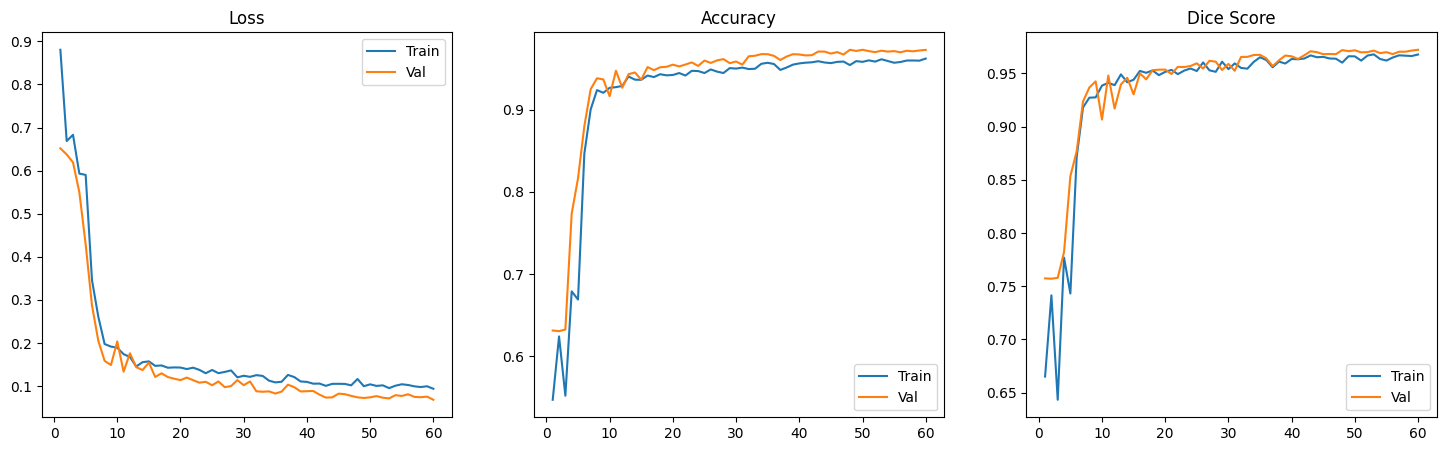

Plot saved to training_history.png


In [19]:
BASE_DIR = "/home/dhuencho/dev_py/0001_start_pytorch/src/UCL_AI4SD/CW2/attention-mechanism-unet/models_pytorch/"
SAVE_PATH = "best_model_attention_unet.pth"
PLOT_PATH = "training_history.png"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 2 # Adjust based on your VRAM (best trial didn't specify, assuming 4 or 8)
NUM_EPOCHS = 60

train_loader, val_loader = get_dataloaders(batch_size=BATCH_SIZE)

# 2. Instantiate Best Model
# Best Params: depth: 2, filter_base: 64, use_batchnorm: False, dropout_rate: 0.1
model = FlexibleAttentionUNet(
    in_channels=4,
    out_channels=1,
    depth=2, 
    filter_base=64,
    use_batchnorm=False,
    dropout_rate=0.1
)

# 3. Setup Optimizer
# Best Params: lr: 0.000363..., optimizer: Adam
optimizer = optim.Adam(model.parameters(), lr=0.00036324869566766035)
criterion = nn.BCEWithLogitsLoss()

# 4. Train
print("🚀 Starting Final Training...")
history = train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    num_epochs=NUM_EPOCHS, 
    device=DEVICE, 
    save_path=SAVE_PATH
)

# 5. Plot
plot_history(history, PLOT_PATH)

## Old architecture new data

🚀 Starting Final Training...


Epoch 1/60: 100%|██████████| 24/24 [00:00<00:00, 28.34it/s, loss=0.5737, acc=0.6740]


Epoch 1 Results: Train Loss: 0.6421 | Val Loss: 0.6200 | Val Acc: 0.6331 | Val Dice: 0.7455
🔥 New Best Model Saved! (Dice: 0.7455)


Epoch 2/60: 100%|██████████| 24/24 [00:00<00:00, 42.70it/s, loss=0.5253, acc=0.8365]


Epoch 2 Results: Train Loss: 0.5167 | Val Loss: 0.3414 | Val Acc: 0.8960 | Val Dice: 0.9000
🔥 New Best Model Saved! (Dice: 0.9000)


Epoch 3/60: 100%|██████████| 24/24 [00:02<00:00,  8.64it/s, loss=0.1458, acc=0.9415]


Epoch 3 Results: Train Loss: 0.2472 | Val Loss: 0.2493 | Val Acc: 0.9002 | Val Dice: 0.8825


Epoch 4/60: 100%|██████████| 24/24 [00:00<00:00, 38.93it/s, loss=0.2842, acc=0.8775]


Epoch 4 Results: Train Loss: 0.2221 | Val Loss: 0.1948 | Val Acc: 0.9216 | Val Dice: 0.9120
🔥 New Best Model Saved! (Dice: 0.9120)


Epoch 5/60: 100%|██████████| 24/24 [00:00<00:00, 38.78it/s, loss=0.1603, acc=0.9340]


Epoch 5 Results: Train Loss: 0.1804 | Val Loss: 0.1716 | Val Acc: 0.9314 | Val Dice: 0.9243
🔥 New Best Model Saved! (Dice: 0.9243)


Epoch 6/60: 100%|██████████| 24/24 [00:00<00:00, 42.03it/s, loss=0.1074, acc=0.9567]


Epoch 6 Results: Train Loss: 0.1598 | Val Loss: 0.1712 | Val Acc: 0.9311 | Val Dice: 0.9282
🔥 New Best Model Saved! (Dice: 0.9282)


Epoch 7/60: 100%|██████████| 24/24 [00:00<00:00, 41.53it/s, loss=0.1413, acc=0.9455]


Epoch 7 Results: Train Loss: 0.1432 | Val Loss: 0.1486 | Val Acc: 0.9427 | Val Dice: 0.9367
🔥 New Best Model Saved! (Dice: 0.9367)


Epoch 8/60: 100%|██████████| 24/24 [00:00<00:00, 41.62it/s, loss=0.2748, acc=0.8836]


Epoch 8 Results: Train Loss: 0.1410 | Val Loss: 0.1315 | Val Acc: 0.9479 | Val Dice: 0.9444
🔥 New Best Model Saved! (Dice: 0.9444)


Epoch 9/60: 100%|██████████| 24/24 [00:00<00:00, 41.42it/s, loss=0.1922, acc=0.9217]


Epoch 9 Results: Train Loss: 0.1348 | Val Loss: 0.1309 | Val Acc: 0.9473 | Val Dice: 0.9438


Epoch 10/60: 100%|██████████| 24/24 [00:00<00:00, 41.93it/s, loss=0.0188, acc=0.9937]


Epoch 10 Results: Train Loss: 0.1291 | Val Loss: 0.1197 | Val Acc: 0.9529 | Val Dice: 0.9491
🔥 New Best Model Saved! (Dice: 0.9491)


Epoch 11/60: 100%|██████████| 24/24 [00:00<00:00, 41.84it/s, loss=0.1261, acc=0.9492]


Epoch 11 Results: Train Loss: 0.1190 | Val Loss: 0.1158 | Val Acc: 0.9545 | Val Dice: 0.9502
🔥 New Best Model Saved! (Dice: 0.9502)


Epoch 12/60: 100%|██████████| 24/24 [00:00<00:00, 41.84it/s, loss=0.0179, acc=0.9946]


Epoch 12 Results: Train Loss: 0.1125 | Val Loss: 0.1089 | Val Acc: 0.9554 | Val Dice: 0.9526
🔥 New Best Model Saved! (Dice: 0.9526)


Epoch 13/60: 100%|██████████| 24/24 [00:00<00:00, 41.71it/s, loss=0.1034, acc=0.9571]


Epoch 13 Results: Train Loss: 0.1087 | Val Loss: 0.1025 | Val Acc: 0.9597 | Val Dice: 0.9564
🔥 New Best Model Saved! (Dice: 0.9564)


Epoch 14/60: 100%|██████████| 24/24 [00:00<00:00, 41.37it/s, loss=0.1140, acc=0.9550]


Epoch 14 Results: Train Loss: 0.1064 | Val Loss: 0.1018 | Val Acc: 0.9588 | Val Dice: 0.9558


Epoch 15/60: 100%|██████████| 24/24 [00:00<00:00, 41.71it/s, loss=0.1026, acc=0.9575]


Epoch 15 Results: Train Loss: 0.1062 | Val Loss: 0.0959 | Val Acc: 0.9619 | Val Dice: 0.9586
🔥 New Best Model Saved! (Dice: 0.9586)


Epoch 16/60: 100%|██████████| 24/24 [00:00<00:00, 41.19it/s, loss=0.1127, acc=0.9522]


Epoch 16 Results: Train Loss: 0.0992 | Val Loss: 0.1040 | Val Acc: 0.9553 | Val Dice: 0.9532


Epoch 17/60: 100%|██████████| 24/24 [00:00<00:00, 41.50it/s, loss=0.0659, acc=0.9735]


Epoch 17 Results: Train Loss: 0.1052 | Val Loss: 0.0912 | Val Acc: 0.9623 | Val Dice: 0.9597
🔥 New Best Model Saved! (Dice: 0.9597)


Epoch 18/60: 100%|██████████| 24/24 [00:00<00:00, 41.09it/s, loss=0.0331, acc=0.9871]


Epoch 18 Results: Train Loss: 0.1004 | Val Loss: 0.0860 | Val Acc: 0.9644 | Val Dice: 0.9622
🔥 New Best Model Saved! (Dice: 0.9622)


Epoch 19/60: 100%|██████████| 24/24 [00:00<00:00, 41.78it/s, loss=0.0618, acc=0.9751]


Epoch 19 Results: Train Loss: 0.0997 | Val Loss: 0.0848 | Val Acc: 0.9668 | Val Dice: 0.9639
🔥 New Best Model Saved! (Dice: 0.9639)


Epoch 20/60: 100%|██████████| 24/24 [00:00<00:00, 41.62it/s, loss=0.1196, acc=0.9495]


Epoch 20 Results: Train Loss: 0.1031 | Val Loss: 0.1022 | Val Acc: 0.9592 | Val Dice: 0.9546


Epoch 21/60: 100%|██████████| 24/24 [00:00<00:00, 41.97it/s, loss=0.0942, acc=0.9611]


Epoch 21 Results: Train Loss: 0.0961 | Val Loss: 0.0819 | Val Acc: 0.9674 | Val Dice: 0.9643
🔥 New Best Model Saved! (Dice: 0.9643)


Epoch 22/60: 100%|██████████| 24/24 [00:00<00:00, 41.38it/s, loss=0.0457, acc=0.9807]


Epoch 22 Results: Train Loss: 0.0884 | Val Loss: 0.0797 | Val Acc: 0.9680 | Val Dice: 0.9654
🔥 New Best Model Saved! (Dice: 0.9654)


Epoch 23/60: 100%|██████████| 24/24 [00:00<00:00, 41.75it/s, loss=0.0973, acc=0.9601]


Epoch 23 Results: Train Loss: 0.0883 | Val Loss: 0.0755 | Val Acc: 0.9702 | Val Dice: 0.9677
🔥 New Best Model Saved! (Dice: 0.9677)


Epoch 24/60: 100%|██████████| 24/24 [00:00<00:00, 41.18it/s, loss=0.0485, acc=0.9790]


Epoch 24 Results: Train Loss: 0.0842 | Val Loss: 0.0779 | Val Acc: 0.9693 | Val Dice: 0.9660


Epoch 25/60: 100%|██████████| 24/24 [00:00<00:00, 41.71it/s, loss=0.1179, acc=0.9514]


Epoch 25 Results: Train Loss: 0.0854 | Val Loss: 0.0722 | Val Acc: 0.9711 | Val Dice: 0.9686
🔥 New Best Model Saved! (Dice: 0.9686)


Epoch 26/60: 100%|██████████| 24/24 [00:00<00:00, 37.94it/s, loss=0.0742, acc=0.9692]


Epoch 26 Results: Train Loss: 0.0846 | Val Loss: 0.0712 | Val Acc: 0.9727 | Val Dice: 0.9699
🔥 New Best Model Saved! (Dice: 0.9699)


Epoch 27/60: 100%|██████████| 24/24 [00:00<00:00, 40.25it/s, loss=0.0424, acc=0.9825]


Epoch 27 Results: Train Loss: 0.0842 | Val Loss: 0.0666 | Val Acc: 0.9732 | Val Dice: 0.9710
🔥 New Best Model Saved! (Dice: 0.9710)


Epoch 28/60: 100%|██████████| 24/24 [00:00<00:00, 41.21it/s, loss=0.1806, acc=0.9259]


Epoch 28 Results: Train Loss: 0.0849 | Val Loss: 0.0797 | Val Acc: 0.9675 | Val Dice: 0.9647


Epoch 29/60: 100%|██████████| 24/24 [00:00<00:00, 41.82it/s, loss=0.0346, acc=0.9846]


Epoch 29 Results: Train Loss: 0.0910 | Val Loss: 0.0726 | Val Acc: 0.9729 | Val Dice: 0.9699


Epoch 30/60: 100%|██████████| 24/24 [00:00<00:00, 41.52it/s, loss=0.1294, acc=0.9452]


Epoch 30 Results: Train Loss: 0.0842 | Val Loss: 0.0647 | Val Acc: 0.9743 | Val Dice: 0.9721
🔥 New Best Model Saved! (Dice: 0.9721)


Epoch 31/60: 100%|██████████| 24/24 [00:00<00:00, 41.49it/s, loss=0.0666, acc=0.9720]


Epoch 31 Results: Train Loss: 0.0829 | Val Loss: 0.0702 | Val Acc: 0.9697 | Val Dice: 0.9678


Epoch 32/60: 100%|██████████| 24/24 [00:00<00:00, 41.80it/s, loss=0.0555, acc=0.9765]


Epoch 32 Results: Train Loss: 0.0796 | Val Loss: 0.0618 | Val Acc: 0.9756 | Val Dice: 0.9736
🔥 New Best Model Saved! (Dice: 0.9736)


Epoch 33/60: 100%|██████████| 24/24 [00:00<00:00, 41.71it/s, loss=0.0725, acc=0.9700]


Epoch 33 Results: Train Loss: 0.0789 | Val Loss: 0.0631 | Val Acc: 0.9767 | Val Dice: 0.9745
🔥 New Best Model Saved! (Dice: 0.9745)


Epoch 34/60: 100%|██████████| 24/24 [00:00<00:00, 41.48it/s, loss=0.0618, acc=0.9739]


Epoch 34 Results: Train Loss: 0.0812 | Val Loss: 0.0589 | Val Acc: 0.9773 | Val Dice: 0.9754
🔥 New Best Model Saved! (Dice: 0.9754)


Epoch 35/60: 100%|██████████| 24/24 [00:00<00:00, 39.06it/s, loss=0.0731, acc=0.9689]


Epoch 35 Results: Train Loss: 0.0753 | Val Loss: 0.0593 | Val Acc: 0.9776 | Val Dice: 0.9758
🔥 New Best Model Saved! (Dice: 0.9758)


Epoch 36/60: 100%|██████████| 24/24 [00:00<00:00, 37.53it/s, loss=0.0089, acc=0.9966]


Epoch 36 Results: Train Loss: 0.0813 | Val Loss: 0.0564 | Val Acc: 0.9776 | Val Dice: 0.9758
🔥 New Best Model Saved! (Dice: 0.9758)


Epoch 37/60: 100%|██████████| 24/24 [00:00<00:00, 38.82it/s, loss=0.0618, acc=0.9737]


Epoch 37 Results: Train Loss: 0.0838 | Val Loss: 0.0792 | Val Acc: 0.9727 | Val Dice: 0.9688


Epoch 38/60: 100%|██████████| 24/24 [00:00<00:00, 41.35it/s, loss=0.0608, acc=0.9744]


Epoch 38 Results: Train Loss: 0.0871 | Val Loss: 0.0641 | Val Acc: 0.9761 | Val Dice: 0.9734


Epoch 39/60: 100%|██████████| 24/24 [00:00<00:00, 40.69it/s, loss=0.0778, acc=0.9673]


Epoch 39 Results: Train Loss: 0.0773 | Val Loss: 0.0628 | Val Acc: 0.9765 | Val Dice: 0.9738


Epoch 40/60: 100%|██████████| 24/24 [00:00<00:00, 41.01it/s, loss=0.0507, acc=0.9788]


Epoch 40 Results: Train Loss: 0.0786 | Val Loss: 0.0687 | Val Acc: 0.9750 | Val Dice: 0.9723


Epoch 41/60: 100%|██████████| 24/24 [00:00<00:00, 41.35it/s, loss=0.0596, acc=0.9757]


Epoch 41 Results: Train Loss: 0.0770 | Val Loss: 0.0606 | Val Acc: 0.9758 | Val Dice: 0.9737


Epoch 42/60: 100%|██████████| 24/24 [00:00<00:00, 41.52it/s, loss=0.0257, acc=0.9896]


Epoch 42 Results: Train Loss: 0.0758 | Val Loss: 0.0588 | Val Acc: 0.9786 | Val Dice: 0.9763
🔥 New Best Model Saved! (Dice: 0.9763)


Epoch 43/60: 100%|██████████| 24/24 [00:00<00:00, 40.55it/s, loss=0.0500, acc=0.9789]


Epoch 43 Results: Train Loss: 0.0740 | Val Loss: 0.0552 | Val Acc: 0.9791 | Val Dice: 0.9768
🔥 New Best Model Saved! (Dice: 0.9768)


Epoch 44/60: 100%|██████████| 24/24 [00:00<00:00, 41.39it/s, loss=0.0503, acc=0.9788]


Epoch 44 Results: Train Loss: 0.0773 | Val Loss: 0.0583 | Val Acc: 0.9786 | Val Dice: 0.9761


Epoch 45/60: 100%|██████████| 24/24 [00:00<00:00, 39.77it/s, loss=0.1163, acc=0.9507]


Epoch 45 Results: Train Loss: 0.0708 | Val Loss: 0.0560 | Val Acc: 0.9796 | Val Dice: 0.9775
🔥 New Best Model Saved! (Dice: 0.9775)


Epoch 46/60: 100%|██████████| 24/24 [00:00<00:00, 39.27it/s, loss=0.0834, acc=0.9659]


Epoch 46 Results: Train Loss: 0.0705 | Val Loss: 0.0591 | Val Acc: 0.9790 | Val Dice: 0.9764


Epoch 47/60: 100%|██████████| 24/24 [00:00<00:00, 38.77it/s, loss=0.0766, acc=0.9671]


Epoch 47 Results: Train Loss: 0.0766 | Val Loss: 0.0525 | Val Acc: 0.9812 | Val Dice: 0.9794
🔥 New Best Model Saved! (Dice: 0.9794)


Epoch 48/60: 100%|██████████| 24/24 [00:00<00:00, 41.41it/s, loss=0.0746, acc=0.9693]


Epoch 48 Results: Train Loss: 0.0732 | Val Loss: 0.0516 | Val Acc: 0.9814 | Val Dice: 0.9796
🔥 New Best Model Saved! (Dice: 0.9796)


Epoch 49/60: 100%|██████████| 24/24 [00:00<00:00, 41.37it/s, loss=0.1586, acc=0.9336]


Epoch 49 Results: Train Loss: 0.0708 | Val Loss: 0.0538 | Val Acc: 0.9801 | Val Dice: 0.9781


Epoch 50/60: 100%|██████████| 24/24 [00:00<00:00, 41.30it/s, loss=0.0509, acc=0.9788]


Epoch 50 Results: Train Loss: 0.0825 | Val Loss: 0.0584 | Val Acc: 0.9761 | Val Dice: 0.9742


Epoch 51/60: 100%|██████████| 24/24 [00:00<00:00, 41.08it/s, loss=0.0676, acc=0.9710]


Epoch 51 Results: Train Loss: 0.0771 | Val Loss: 0.0565 | Val Acc: 0.9771 | Val Dice: 0.9751


Epoch 52/60: 100%|██████████| 24/24 [00:00<00:00, 41.41it/s, loss=0.0745, acc=0.9684]


Epoch 52 Results: Train Loss: 0.0731 | Val Loss: 0.0506 | Val Acc: 0.9820 | Val Dice: 0.9806
🔥 New Best Model Saved! (Dice: 0.9806)


Epoch 53/60: 100%|██████████| 24/24 [00:00<00:00, 41.27it/s, loss=0.0720, acc=0.9697]


Epoch 53 Results: Train Loss: 0.0691 | Val Loss: 0.0600 | Val Acc: 0.9801 | Val Dice: 0.9775


Epoch 54/60: 100%|██████████| 24/24 [00:00<00:00, 40.93it/s, loss=0.0729, acc=0.9696]


Epoch 54 Results: Train Loss: 0.0734 | Val Loss: 0.0539 | Val Acc: 0.9805 | Val Dice: 0.9783


Epoch 55/60: 100%|██████████| 24/24 [00:00<00:00, 41.02it/s, loss=0.0500, acc=0.9790]


Epoch 55 Results: Train Loss: 0.0698 | Val Loss: 0.0574 | Val Acc: 0.9805 | Val Dice: 0.9779


Epoch 56/60: 100%|██████████| 24/24 [00:00<00:00, 41.00it/s, loss=0.1734, acc=0.9278]


Epoch 56 Results: Train Loss: 0.0750 | Val Loss: 0.0553 | Val Acc: 0.9803 | Val Dice: 0.9789


Epoch 57/60: 100%|██████████| 24/24 [00:00<00:00, 41.16it/s, loss=0.0873, acc=0.9638]


Epoch 57 Results: Train Loss: 0.0772 | Val Loss: 0.0528 | Val Acc: 0.9812 | Val Dice: 0.9788


Epoch 58/60: 100%|██████████| 24/24 [00:00<00:00, 40.34it/s, loss=0.0612, acc=0.9739]


Epoch 58 Results: Train Loss: 0.0746 | Val Loss: 0.0570 | Val Acc: 0.9808 | Val Dice: 0.9792


Epoch 59/60: 100%|██████████| 24/24 [00:00<00:00, 41.23it/s, loss=0.0556, acc=0.9755]


Epoch 59 Results: Train Loss: 0.0739 | Val Loss: 0.0699 | Val Acc: 0.9735 | Val Dice: 0.9701


Epoch 60/60: 100%|██████████| 24/24 [00:00<00:00, 40.57it/s, loss=0.0252, acc=0.9902]


Epoch 60 Results: Train Loss: 0.0767 | Val Loss: 0.0521 | Val Acc: 0.9819 | Val Dice: 0.9799


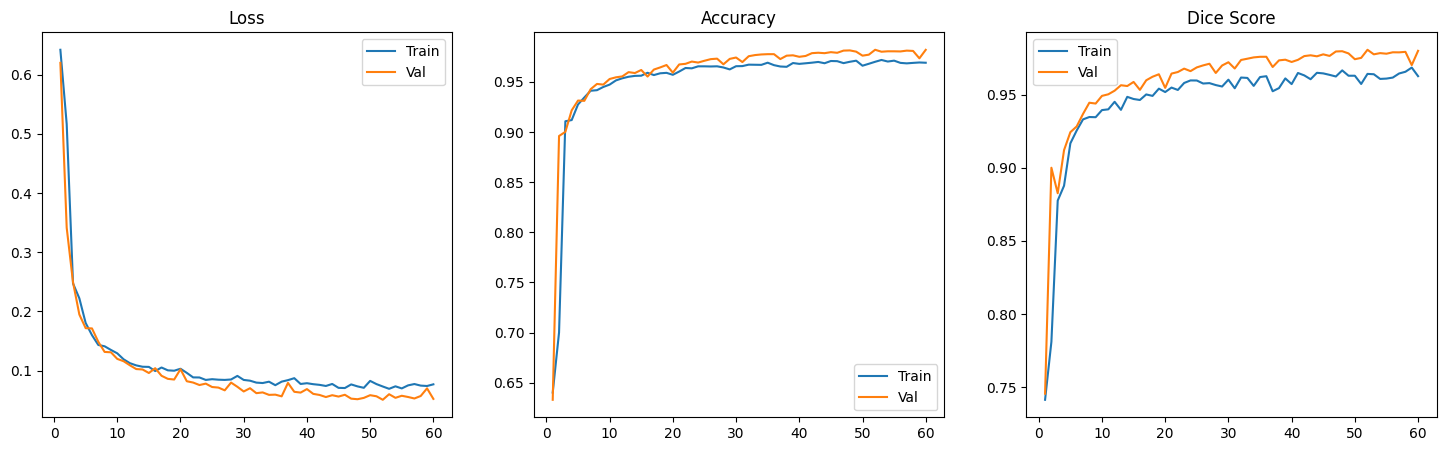

Plot saved to training_history_old.png


In [18]:
BASE_DIR = "/home/dhuencho/dev_py/0001_start_pytorch/src/UCL_AI4SD/CW2/attention-mechanism-unet/models_pytorch/"
SAVE_PATH = "old_model_attention_unet_clp.pth"
PLOT_PATH = "training_history_old.png"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 1 # Adjust based on your VRAM (best trial didn't specify, assuming 4 or 8)
NUM_EPOCHS = 60

train_loader, val_loader = get_dataloaders(batch_size=BATCH_SIZE)

# 2. Instantiate Best Model
# Best Params: depth: 2, filter_base: 64, use_batchnorm: False, dropout_rate: 0.1
model = FlexibleAttentionUNet(
    in_channels=4,
    out_channels=1,
    depth=4, 
    filter_base=16,
    use_batchnorm=False,
    dropout_rate=0.0
)

# 3. Setup Optimizer
# Best Params: lr: 0.000363..., optimizer: Adam
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCEWithLogitsLoss()

# 4. Train
print("🚀 Starting Final Training...")
history = train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    num_epochs=NUM_EPOCHS, 
    device=DEVICE, 
    save_path=SAVE_PATH
)

# 5. Plot
plot_history(history, PLOT_PATH)

## pp   


In [20]:
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score

def get_prediction(model, image_tensor, device='cuda'):
    """
    Runs inference on a single image or batch.
    Args:
        model: PyTorch model
        image_tensor: Tensor (C, H, W) or (B, C, H, W)
    Returns:
        pred_mask: Binary numpy array (0 or 1)
    """
    model.eval()
    
    # Handle dimension: Add Batch dim if missing (C, H, W) -> (1, C, H, W)
    if len(image_tensor.shape) == 3:
        image_tensor = image_tensor.unsqueeze(0)
        
    image_tensor = image_tensor.to(device)
    
    with torch.no_grad():
        logits = model(image_tensor)
        probs = torch.sigmoid(logits) # Apply Sigmoid since we removed it from the model
        preds = (probs > 0.5).float() # Threshold at 0.5
        
    # Convert to CPU Numpy for metrics
    return preds.cpu().numpy()

In [21]:
def measure_inference_time(model, device='cuda', input_size=(1, 3, 512, 512)):
    """
    Measures pure inference time on the GPU.
    """
    model.to(device)
    model.eval()
    
    # Create dummy input
    dummy_input = torch.randn(input_size).to(device)
    
    # Warmup GPU (important for accurate timing)
    for _ in range(10):
        _ = model(dummy_input)
        
    torch.cuda.synchronize() # Wait for GPU to finish warmup
    
    start_time = time.time()
    for _ in range(100): # Average over 100 runs
        _ = model(dummy_input)
    torch.cuda.synchronize() # Wait for GPU to finish
    end_time = time.time()
    
    avg_time = (end_time - start_time) / 100
    print(f"Average Inference Time: {avg_time*1000:.2f} ms per image")
    return avg_time

def evaluate_metrics(model, dataloader, device='cuda'):
    """
    Computes Jaccard (IoU) and Dice Score over the entire test set.
    """
    model.eval()
    jaccard_scores = []
    dice_scores = []
    accuracy_scores = []
    mse_scores = []
    
    print(f"Evaluating over {len(dataloader)} batches...")
    
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            # Ensure masks are on CPU numpy for sklearn/manual calc
            masks_np = masks.numpy().flatten()
            
            # Predict
            logits = model(images)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            preds_np = preds.cpu().numpy().flatten()
            probs_np = probs.cpu().numpy().flatten()
            
            # --- Jaccard (IoU) ---
            # 'binary' ensures we check matching 1s (Forest), excluding background
            iou = jaccard_score(masks_np, preds_np, average='binary') 
            jaccard_scores.append(iou)
            
            # --- Dice Coefficient ---
            # Formula: 2*Intersection / (Sum + Epsilon)
            intersection = np.logical_and(masks_np, preds_np).sum()
            dice = (2. * intersection + 1e-6) / (masks_np.sum() + preds_np.sum() + 1e-6)
            dice_scores.append(dice)

            # --- 3. Accuracy ---
            # Fraction of pixels where Prediction matches Truth
            acc = (preds_np == masks_np).mean()
            accuracy_scores.append(acc)
            
            # --- 4. Mean Squared Error (MSE) ---
            # Error between Probability (Continuous) and Truth (Binary)
            mse = ((probs_np - masks_np) ** 2).mean()
            mse_scores.append(mse)

            
    mean_iou = np.mean(jaccard_scores)
    std_iou = np.std(jaccard_scores)
    mean_dice = np.mean(dice_scores)
    std_dice = np.std(dice_scores)  
    mean_acc = np.mean(accuracy_scores)
    std_acc = np.std(accuracy_scores)
    mean_mse = np.mean(mse_scores)
    std_mse = np.std(mse_scores)

    
    print(f"\n--- Results ---")
    print(f"Jaccard Index (IoU): {mean_iou:.4f} ± {std_iou:.4f}")
    print(f"Dice Coefficient:    {mean_dice:.4f} ± {std_dice:.4f}")
    print(f"Accuracy:            {mean_acc:.4f} ± {std_acc:.4f}")
    print(f"MSE:                 {mean_mse:.6f} ± {std_mse:.6f}")
    
    
    return mean_iou, mean_dice

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def visualize_predictions(model, dataloader, device='cuda', num_samples=3):
    """
    Plots [Image, Mask, Prediction] for 'num_samples' images.
    Calculates and displays Dice Score in the title.
    """
    model.eval()
    
    # 1. Accumulate enough samples
    accumulated_images = []
    accumulated_masks = []
    accumulated_preds = []
    
    # Iterate through the loader until we have enough samples
    for batch_images, batch_masks in dataloader:
        if len(accumulated_images) >= num_samples:
            break
            
        # Move to GPU for prediction
        images_gpu = batch_images.to(device)
        
        with torch.no_grad():
            logits = model(images_gpu)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
        
        # Move back to CPU and add to list
        for i in range(len(batch_images)):
            if len(accumulated_images) >= num_samples:
                break
                
            img_np = batch_images[i].permute(1, 2, 0).numpy() # (H, W, C)
            mask_np = batch_masks[i].numpy().squeeze()        # (H, W)
            pred_np = preds[i].cpu().numpy().squeeze()        # (H, W)
            
            accumulated_images.append(img_np)
            accumulated_masks.append(mask_np)
            accumulated_preds.append(pred_np)

    # 2. Plotting
    print(f"Visualizing {len(accumulated_images)} samples...")
    
    plt.figure(figsize=(15, 5 * len(accumulated_images)))
    
    for i in range(len(accumulated_images)):
        # Retrieve arrays
        mask_t = accumulated_masks[i]
        pred_t = accumulated_preds[i]

        # --- METRIC CALCULATION ---
        # Dice = 2 * Intersection / (Sum of pixels in both)
        intersection = np.logical_and(mask_t, pred_t).sum()
        total_pixels = mask_t.sum() + pred_t.sum()
        
        if total_pixels == 0:
            # If both mask and prediction are empty, score is perfect (1.0)
            dice_score = 1.0
        else:
            dice_score = (2. * intersection) / total_pixels

        # Optional: Pixel Accuracy
        accuracy = (mask_t == pred_t).mean()
        # --------------------------

        # A. Original Image
        plt.subplot(len(accumulated_images), 3, i*3 + 1)
        plt.imshow(accumulated_images[i])
        plt.title(f"Sample {i+1}: Satellite Image")
        plt.axis('off')
        
        # B. Ground Truth (Forest=1=White)
        plt.subplot(len(accumulated_images), 3, i*3 + 2)
        plt.imshow(mask_t, cmap='gray', vmin=0, vmax=1)
        plt.title("Ground Truth Mask")
        plt.axis('off')
        
        # C. Model Prediction (WITH SCORE)
        plt.subplot(len(accumulated_images), 3, i*3 + 3)
        plt.imshow(pred_t, cmap='gray', vmin=0, vmax=1)
        
        # Color code the title: Green if good (>0.8), Red if bad
        title_color = 'green' if dice_score > 0.8 else 'red'
        
        plt.title(f"Prediction\nDice: {dice_score:.4f} | Acc: {accuracy:.2f}", 
                  color=title_color, fontweight='bold')
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

In [25]:

# Load Model Example

def load_model(model_class, model_path, in_channels=4, **kwargs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load the file
    checkpoint = torch.load(model_path, map_location=device)
    
    # Instantiate the model architecture
    model = model_class(in_channels=in_channels, **kwargs)
    
    # Robustly load weights
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        # Case 1: Saved as a dictionary with metadata (e.g., optimizer state, epoch)
        print(f"Loading '{model_path}' from dictionary checkpoint...")
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        # Case 2: Saved as a direct state_dict
        print(f"Loading '{model_path}' directly from state_dict...")
        model.load_state_dict(checkpoint)

    model.to(device)
    model.eval()
    return model

# Example: Load Attention U-Net 4-Band
attn_unet_4band = load_model(AttentionUNet, 'models_pytorch/attention-unet-4d.pth', in_channels=4)

old_clp = load_model(FlexibleAttentionUNet, 'models_pytorch/old_model_attention_unet_clp.pth', in_channels=4, depth=4, filter_base=16, use_batchnorm=False, dropout_rate=0.0)

new_clp = load_model(FlexibleAttentionUNet, 'models_pytorch/best_model_attention_unet_clp.pth', in_channels=4, depth=2, filter_base=64, use_batchnorm=False, dropout_rate=0.1)


/tmp/ipykernel_169162/1404210755.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Loading 'models_pytorch/attention-unet-4d.pth' from dictionary checkpoint...
Loading 'models_pytorch/old_model_attention_unet_clp.pth' directly from state_dict...
Loading 'models_pytorch/best_model_attention_unet_clp.pth' directly from state_dict...


In [28]:
# 1. Check speed
measure_inference_time(attn_unet_4band, input_size=(1, 4, 512, 512))
measure_inference_time(old_clp, input_size=(1, 4, 512, 512))
measure_inference_time(new_clp, input_size=(1, 4, 512, 512))

# 2. Check accuracy metrics
evaluate_metrics(attn_unet_4band, val_loader)
evaluate_metrics(old_clp, val_loader)
evaluate_metrics(new_clp, val_loader)

# 3. See the results
#visualize_predictions(attn_unet_4band, val_loader, num_samples=2)

Average Inference Time: 4.62 ms per image
Average Inference Time: 4.33 ms per image
Average Inference Time: 25.93 ms per image
Evaluating over 8 batches...

--- Results ---
Jaccard Index (IoU): 0.8680 ± 0.0662
Dice Coefficient:    0.9279 ± 0.0386
Accuracy:            0.9249 ± 0.0251
MSE:                 0.053688 ± 0.016961
Evaluating over 8 batches...

--- Results ---
Jaccard Index (IoU): 0.9648 ± 0.0276
Dice Coefficient:    0.9819 ± 0.0146
Accuracy:            0.9820 ± 0.0083
MSE:                 0.014101 ± 0.006068
Evaluating over 8 batches...

--- Results ---
Jaccard Index (IoU): 0.9472 ± 0.0485
Dice Coefficient:    0.9722 ± 0.0268
Accuracy:            0.9730 ± 0.0151
MSE:                 0.020089 ± 0.011060


(np.float64(0.9472005411841182), np.float64(0.9722184130616887))

In [33]:
base_dir2 = r"./chile/"

def get_4band_files(base_dir, split="Training"):
    # Define folder names based on the split (handling the inconsistency)
    if split == "Training":
        img_folder, mask_folder = "image", "label"
    elif split == "Test":
        img_folder, mask_folder = "images", "masks"
    elif split == "Validation":
        img_folder, mask_folder = "images", "masks"
        
    # Get Paths
    img_path = os.path.join(base_dir, split, img_folder)
    mask_path = os.path.join(base_dir, split, mask_folder)
    
    # Get List
    image_files = sorted(glob.glob(os.path.join(img_path, "*")))
    
    # Match masks (Assuming same filename)
    mask_files = []
    for img in image_files:
        filename = os.path.basename(img)
        mask_files.append(os.path.join(mask_path, filename))
        
    return image_files, mask_files

# --- LOAD DATA ---
# 1. Get Lists
#train_imgs, train_masks = get_4band_files(base_dir2, "Training")
test_imgs, test_masks = get_4band_files(base_dir2, "Test")

# 2. Create Datasets (Don't forget the transform!)
# train_ds_4band = FourBandAmazonDataset(
#     train_imgs, 
#     train_masks, 
#     transform=get_4band_transforms("train")
# )

test_ds_4band_cl = FourBandAmazonDataset(
    test_imgs, 
    test_masks, 
    transform=get_4band_transforms("test")
)

# 3. DataLoaders
#train_loader_4band = DataLoader(train_ds_4band, batch_size=2, shuffle=True, num_workers=2)
test_loader_4band_cl = DataLoader(test_ds_4band_cl, batch_size=2, shuffle=False, num_workers=2)

print("✅ 4-Band Pipeline Ready") 

✅ 4-Band Pipeline Ready


In [34]:
# 1. Check speed
measure_inference_time(attn_unet_4band, input_size=(1, 4, 512, 512))
measure_inference_time(old_clp, input_size=(1, 4, 512, 512))
measure_inference_time(new_clp, input_size=(1, 4, 512, 512))

# 2. Check accuracy metrics
evaluate_metrics(attn_unet_4band, test_loader_4band_cl)
evaluate_metrics(old_clp, test_loader_4band_cl)
evaluate_metrics(new_clp, test_loader_4band_cl)

# 3. See the results

Average Inference Time: 4.47 ms per image
Average Inference Time: 4.22 ms per image
Average Inference Time: 25.27 ms per image
Evaluating over 3 batches...

--- Results ---
Jaccard Index (IoU): 0.7962 ± 0.0432
Dice Coefficient:    0.8859 ± 0.0267
Accuracy:            0.9082 ± 0.0141
MSE:                 0.065705 ± 0.009790
Evaluating over 3 batches...

--- Results ---
Jaccard Index (IoU): 0.9410 ± 0.0212
Dice Coefficient:    0.9695 ± 0.0113
Accuracy:            0.9722 ± 0.0125
MSE:                 0.021374 ± 0.008791
Evaluating over 3 batches...

--- Results ---
Jaccard Index (IoU): 0.9132 ± 0.0320
Dice Coefficient:    0.9543 ± 0.0174
Accuracy:            0.9577 ± 0.0194
MSE:                 0.030830 ± 0.013440


(np.float64(0.9131681093811449), np.float64(0.9543221052971839))

## pp   
